In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import pytz


In [37]:
def transform_crypto_data(data: pd.DataFrame) -> pd.DataFrame:
    """
    This function adds the following columns to our bitcoin dataframe:
    %PriceChange: To look at price change within a day
    priceDiff: To look at the per day absolute price change
    normalizedVol: To compare relative trading activity
    7DayMovingAvgPrice: To be able to observe long-term effects
    30DayMovingAvgPrice: To be able to observe long-term effects
    7DayMovingAvgVol: To be able to observe long-term effects
    30DayMovingAvgVol: To be able to observe long-term effects
    
    Note: The first 7 or 30 values for Moving averages for a week or month, respectively,
        are NaN values because there aren't sufficient rows to calculate the average. 
        We have decided to leave these values as NaN to preserve data integrity and not fill
        them which could possibly distort our analysis.
    
    TODO: Add doctests to see if the calculations are correct
    
    :param data: bitcoin dataframe
    :return: data: bitcoin dataframe with the columns above
    """
    # Adding column for % Price Change per day 
    data['%PriceChange'] = round(((data['Close'] - data['Open']) / data['Open']) * 100, 3)
    
    # Normalizing %PriceChange
    data['normalizedPriceChange'] = data['%PriceChange'] / data['%PriceChange'].abs().max()
    
    # Adding column for price difference
    data['priceDiff'] = round(data['Close'] - data['Open'], 3)
    
    # Adding column to look at the normalized trading volume
    data['normalizedVol'] = data['Volume'] / data['Volume'].max()
    
    # Adding columns for moving averages to compare long-term results
    # Learnt about the rolling function through ChatGPT
    data['7DayMovingAvgPrice'] = round(data['Close'].rolling(window=7).mean(), 3)
    data['30DayMovingAvgPrice'] = round(data['Close'].rolling(window=30).mean(), 3)
    data['7DayMovingAvgVol'] = data['normalizedVol'].rolling(window=7).mean()
    data['30DayMovingAvgVol'] = data['normalizedVol'].rolling(window=30).mean()
    
    return data

In [38]:
def get_crypto_data(filename: str) -> pd.DataFrame:
    """
    Reads the bitcoin csv data into a pandas dataframe.
    
    :param filename: bitcoin csv file name
    :return: df: bitcoin data as a pandas dataframe
    """
    
    df = pd.read_csv(filename)
    
    # converting 'Date' column to pd.datetime format to perform calculations
    df['Date'] = pd.to_datetime(df['Date'], utc=True)
    
    df = transform_crypto_data(df)
    
    return df

In [39]:
bitcoin_df = get_crypto_data('bitcoin_historical_data.csv')

In [40]:
eth_df = get_crypto_data('ETH_data.csv')

### Reading Policy Data into Pandas DataFrame

In [42]:
def get_US_law_data(filename: str) -> pd.DataFrame:
    """
    This function reads the US Law data csv file into a pandas dataframe.
    
    :param filename: name of file with US Law data
    :return: dataframe containing US Law data
    """
    
    df = pd.read_csv(filename)
    
    df['Date of Introduction'] = pd.to_datetime(df['Date of Introduction'])
    df['Latest Action Date'] = pd.to_datetime(df['Latest Action Date'])
    
    # Making law data timezone aware to EST, since bitcoin data is timezone-aware
    df['Date of Introduction'] = df['Date of Introduction'].dt.tz_localize('UTC')
    est_tz = pytz.timezone('US/Eastern')
    df['Date of Introduction'] = df['Date of Introduction'].dt.tz_convert(est_tz)
    
    return df

In [43]:
law_df = get_US_law_data('results_US.csv')

### Adding Event Period Flag to Crypto Data
* If the date from cryptocurrency data is within a week from Policy date (Date of Introduction), it is flagged as 1, else 0

In [44]:
def event_period_flag(row, eventdates):
    for eventdate in eventdates:
        # Event window: 7 days from the event date/ 1 week
        event_startwindow = eventdate
        event_endwindow = eventdate + pd.Timedelta(days=7)  # 7-day window from the event date
        
        # 1 if date falls during an event, 0 if it does not
        if event_startwindow <= row <= event_endwindow:
            return 1  # DuringEvent
    
    return 0

In [45]:
# Adding column 'EventPeriod' to bitcoin_df. It is a flag where 1 means the date was during an event (bill introduction)
event_dates = law_df['Date of Introduction'].tolist()
bitcoin_df['EventPeriod'] = bitcoin_df['Date'].apply(lambda x: event_period_flag(x, event_dates))
eth_df['EventPeriod'] = eth_df['Date'].apply(lambda x: event_period_flag(x, event_dates))

In [46]:
bitcoin_df[bitcoin_df['Date'] == '2014-12-02 00:00:00+00:00']

Date    Open        High         Low       Close  \
76 2014-12-02 00:00:00+00:00  379.25  384.037994  377.863007  381.315002   

      Volume  Dividends  Stock Splits  %PriceChange  normalizedPriceChange  \
76  12364100        0.0           0.0         0.544               0.014629   

    priceDiff  normalizedVol  7DayMovingAvgPrice  30DayMovingAvgPrice  \
76      2.065       0.000035             375.512               369.73   

    7DayMovingAvgVol  30DayMovingAvgVol  EventPeriod  
76           0.00004           0.000063            1

In [51]:
eth_df['Date'].max()

Timestamp('2024-10-31 00:00:00+0000', tz='UTC')

In [47]:
eth_df[eth_df['Date'] == '2014-12-02 00:00:00+00:00']

Empty DataFrame
Columns: [Date, Adj Close, Close, High, Low, Open, Volume, %PriceChange, normalizedPriceChange, priceDiff, normalizedVol, 7DayMovingAvgPrice, 30DayMovingAvgPrice, 7DayMovingAvgVol, 30DayMovingAvgVol, EventPeriod]
Index: []

### Studying Price trends within our Bitcoin data: Exploratory Data Analysis

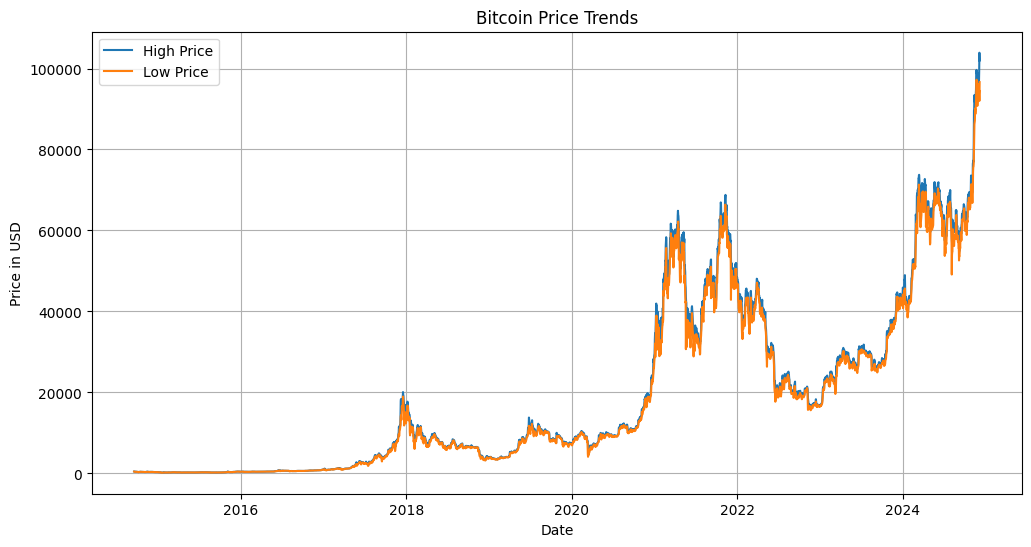

In [5]:
# Observing price trends (Open, High, Low, Close)
plt.figure(figsize=(12, 6))
plt.plot(bitcoin_df['Date'], bitcoin_df['Open'], label='Open Price')
plt.plot(bitcoin_df['Date'], bitcoin_df['High'], label='High Price')
plt.plot(bitcoin_df['Date'], bitcoin_df['Low'], label='Low Price')
plt.plot(bitcoin_df['Date'], bitcoin_df['Close'], label='Close Price')
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.title('Bitcoin Price Trends')
plt.legend()
plt.grid(True)
plt.show()

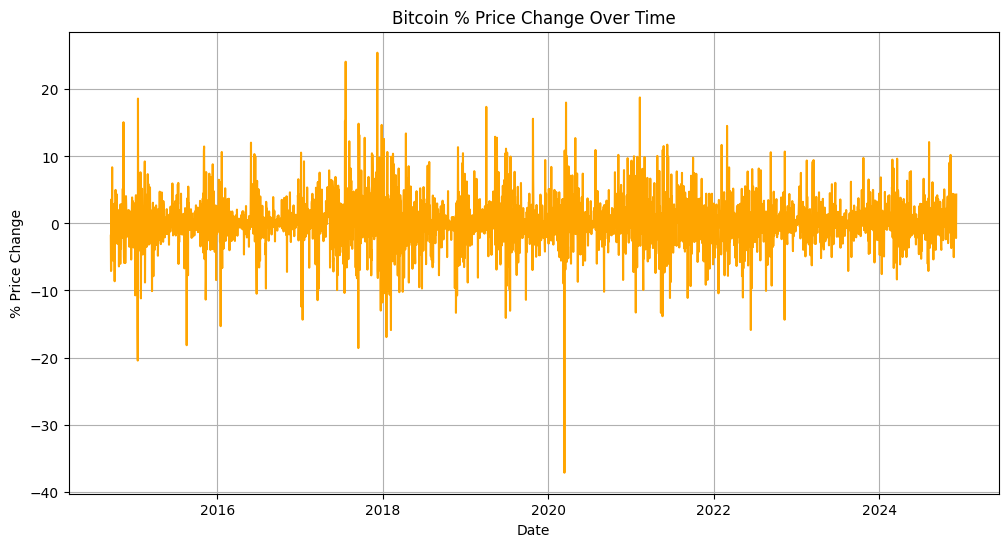

In [6]:
#  % price change over time
plt.figure(figsize=(12, 6))
plt.plot(bitcoin_df['Date'], bitcoin_df['%PriceChange'], label='% Price Change', color='orange')
plt.xlabel('Date')
plt.ylabel('% Price Change')
plt.title('Bitcoin % Price Change Over Time')
plt.grid(True)
plt.show()

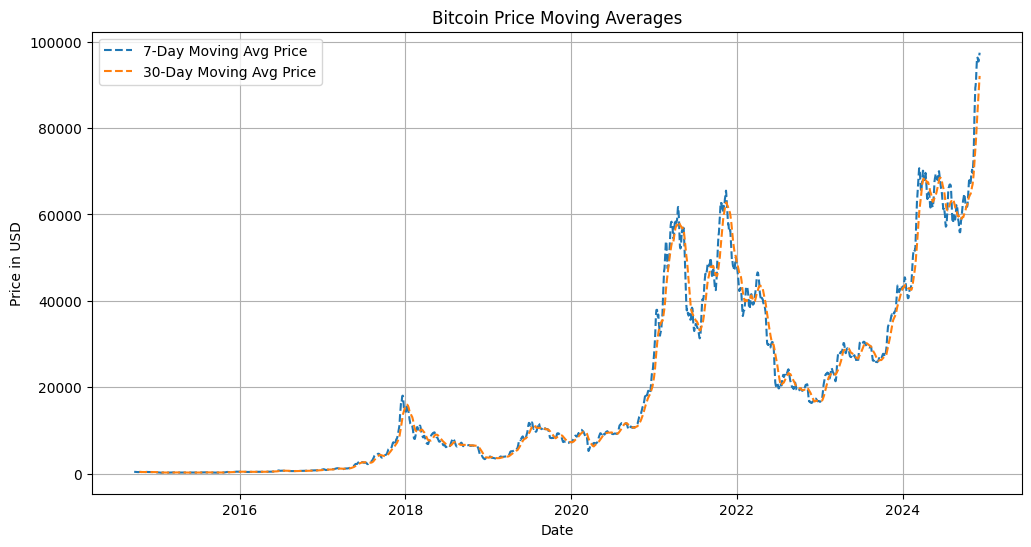

In [7]:
# price averages over time
plt.figure(figsize=(12, 6))
plt.plot(bitcoin_df['Date'], bitcoin_df['7DayMovingAvgPrice'], label='7-Day Moving Avg Price', linestyle='--')
plt.plot(bitcoin_df['Date'], bitcoin_df['30DayMovingAvgPrice'], label='30-Day Moving Avg Price', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.title('Bitcoin Price Moving Averages')
plt.legend()
plt.grid(True)
plt.show()

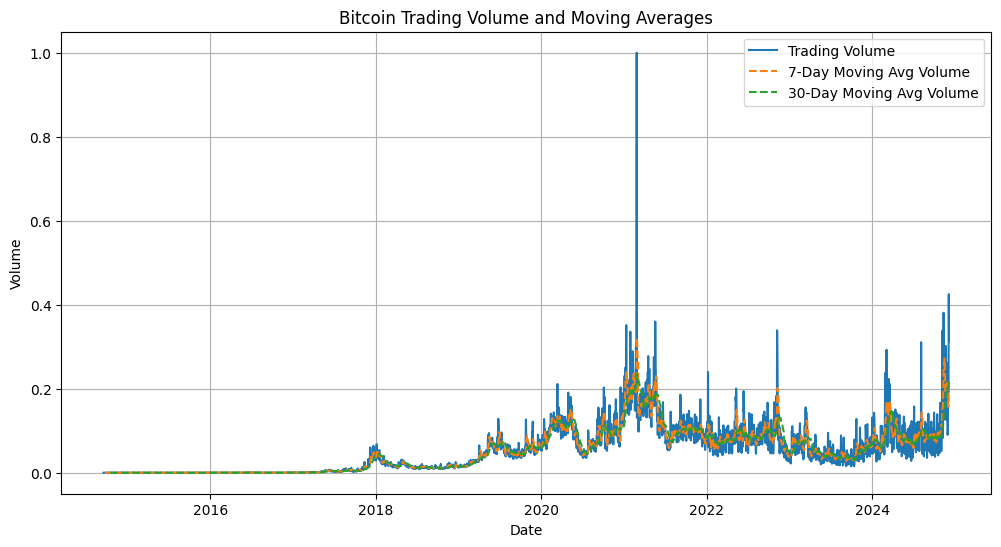

In [8]:
# trading volume averages
plt.figure(figsize=(12, 6))
plt.plot(bitcoin_df['Date'], bitcoin_df['normalizedVol'], label='Trading Volume')
plt.plot(bitcoin_df['Date'], bitcoin_df['7DayMovingAvgVol'], label='7-Day Moving Avg Volume', linestyle='--')
plt.plot(bitcoin_df['Date'], bitcoin_df['30DayMovingAvgVol'], label='30-Day Moving Avg Volume', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.title('Bitcoin Trading Volume and Moving Averages')
plt.legend()
plt.grid(True)
plt.show()

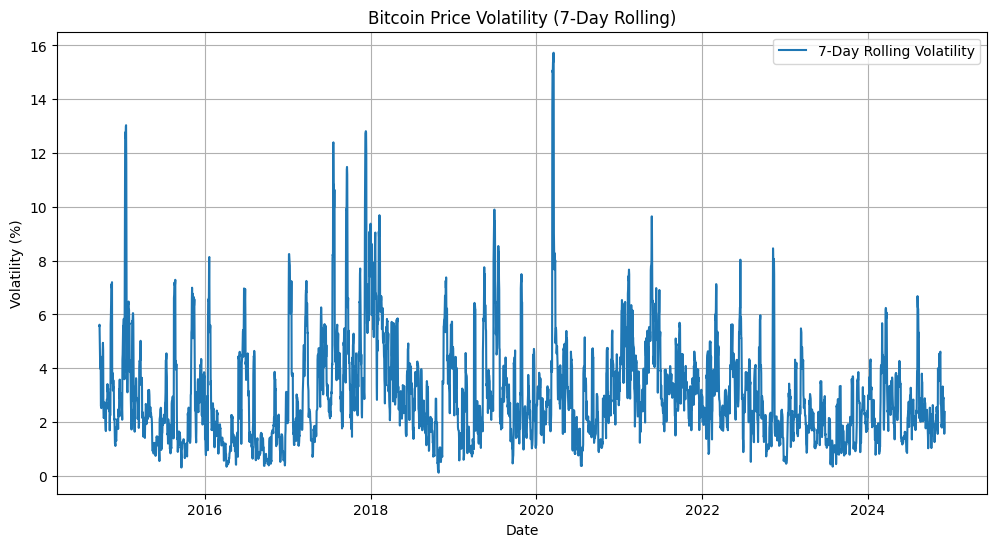

In [52]:
# calculating rolling standard deviation for price change (volatility)
bitcoin_df['Volatility'] = bitcoin_df['%PriceChange'].rolling(window=7).std()

# Plotting the volatility
plt.figure(figsize=(12, 6))
plt.plot(bitcoin_df['Date'], bitcoin_df['Volatility'], label='7-Day Rolling Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility (%)')
plt.title('Bitcoin Price Volatility (7-Day Rolling)')
plt.grid(True)
plt.legend()
plt.show()


### Calculating statistics for observations During the event of a Policy introduction:
* Average price change During vs. Average price change in general (not including cryptocurrency data during an event)
* Volatility during event vs. Volatility for general observations
* Average daily price range (High - Low) for during vs. non-during
* Looking at Volatiltiy and Volume for during vs. non-during

In [26]:
def calculate_avg_price_change(data: pd.DataFrame):
    """
    Calculates the average % price change during the event period.
    
    :param data: bitcoin_df with an 'EventPeriod' column.
    :return: value average % price change
    """
    
    during_event_data = data[data['EventPeriod'] == 1]  # During event
    non_event_data = data[data['EventPeriod'] == 0]

    avg_price_change_during = during_event_data['normalizedPriceChange'].mean() if not during_event_data.empty else 0
    avg_price_change_general = non_event_data['normalizedPriceChange'].mean() if not non_event_data.empty else 0
    
    return [avg_price_change_during, avg_price_change_general]

In [27]:
avg_price_changes = calculate_avg_price_change(bitcoin_df)
avg_price_changes


[np.float64(0.004956017829570779), np.float64(0.005566839199955746)]

In [28]:
def calculate_volatility(data: pd.DataFrame):
    """
    Calculates the price volatility (standard deviation of %PriceChange) during and non-event periods. Gives us a sense of price fluctuation.
    
    :param data: bitcoin_df with an 'EventPeriod' column.
    :return: Dictionary with volatility for both during event and non-event periods.
    """
    
    during_event_data = data[data['EventPeriod'] == 1]
    non_event_data = data[data['EventPeriod'] == 0]

    # calculating the std dev of normalized price change
    volatility_during = during_event_data['normalizedPriceChange'].std() if not during_event_data.empty else 0
    volatility_general = non_event_data['normalizedPriceChange'].std() if not non_event_data.empty else 0
    
    return {'During Event': volatility_during, 'General': volatility_general}

volatility_changes = calculate_volatility(bitcoin_df)
print(volatility_changes)

{'During Event': np.float64(0.0999033079943666), 'General': np.float64(0.09686426902940576)}


In [29]:
def calculate_price_range(data: pd.DataFrame):
    """
    Calculates the average daily price range (high-low difference) during and non-event periods. You can calculate the daily high-low range of the price, which captures the extremes of the price movements and can show how much the price fluctuated within each day. This will help highlight the day-to-day volatility.
    
    :param data: bitcoin_df with an 'EventPeriod' column.
    :return: Dictionary with average price range for both during event and non-event periods.
    """
    
    during_event_data = data[data['EventPeriod'] == 1]
    non_event_data = data[data['EventPeriod'] == 0]

    # calculating avg price range (high - low)
    avg_range_during = (during_event_data['High'] - during_event_data['Low']).mean() if not during_event_data.empty else 0
    avg_range_general = (non_event_data['High'] - non_event_data['Low']).mean() if not non_event_data.empty else 0
    
    return {'During Event': avg_range_during, 'General': avg_range_general}

price_ranges = calculate_price_range(bitcoin_df)
print(price_ranges)

{'During Event': np.float64(1261.7335857958892), 'General': np.float64(816.1615178551556)}


In [30]:
def calculate_avg_volatility_and_volume(data: pd.DataFrame):
    """
    Calculates average price volatility and trading volume during and non-event periods.
    
    :param data: bitcoin_df with an 'EventPeriod' column.
    :return: Dictionary with volatility and volume for both during event and non-event periods.
    """
    
    during_event_data = data[data['EventPeriod'] == 1]
    non_event_data = data[data['EventPeriod'] == 0]

    # calculating price volatility (std of normalized price change)
    volatility_during = during_event_data['normalizedPriceChange'].std() if not during_event_data.empty else 0
    volatility_general = non_event_data['normalizedPriceChange'].std() if not non_event_data.empty else 0
    
    # calculating the avg trading volume
    avg_vol_during = during_event_data['normalizedVol'].mean() if not during_event_data.empty else 0
    avg_vol_general = non_event_data['normalizedVol'].mean() if not non_event_data.empty else 0
    
    return {
        'During Event': {'Volatility': volatility_during, 'Avg Volume': avg_vol_during},
        'General': {'Volatility': volatility_general, 'Avg Volume': avg_vol_general}
    }

volatility_and_volume = calculate_avg_volatility_and_volume(bitcoin_df)
print(volatility_and_volume)


{'During Event': {'Volatility': np.float64(0.0999033079943666), 'Avg Volume': np.float64(0.07706481615393926)}, 'General': {'Volatility': np.float64(0.09686426902940576), 'Avg Volume': np.float64(0.04798910994457853)}}


### Function to create plots that compare Cryptocurrency Trends with Event Period

In [22]:
def plot_quarterly_trend(bitcoin_data: pd.DataFrame, law_data: pd.DataFrame, column_name: str, y_axis_limit=False):
    """
    This function loops through each year from 2018 to 2024 and creates a plot for each quarter to look for trends 
    from two datasets: bitcoin_df and law_df.
    
    :param bitcoin_data: pandas dataframe that contains bitcoin data.
    :param law_data: pandas dataframe that contains data regarding US laws and regulations pertaining to cryptocurrencies, blockchain, or bitcoin.
    :param column_name: This argument allows us to select a column from the bitcoin_df to compare it with the law/regulations data
    :param y_axis_limit: This argument is to set a limit from [-1, 1] for the y-axis. Helps with uniformity when looking at normalized values.
    :return: Does not return anything. Prints out the plots that we observe.
    """
    
    for year in range(2018, 2025):
        for quarter in range(1, 5):
            # defining the start date and end date for the current quarter
            start_date = pd.to_datetime(f'{year}-{(quarter-1)*3+1:02d}-01')
            end_date = pd.to_datetime(f'{year}-{quarter*3:02d}-01') + pd.DateOffset(months=1) - pd.Timedelta(days=1)
    
            # converting start_date and end_date to UTC
            start_date = start_date.tz_localize('US/Eastern').tz_convert('UTC')
            end_date = end_date.tz_localize('US/Eastern').tz_convert('UTC')
    
            # filtering out bitcoin data for the quarter
            bitcoin_df_quarter = bitcoin_data[(bitcoin_data['Date'] >= start_date) & (bitcoin_data['Date'] <= end_date)]
    
            # filtering out event dates for the quarter
            event_dates_quarter = law_data[(law_data['Date of Introduction'] >= start_date) & 
                                          (law_data['Date of Introduction'] <= end_date)]['Date of Introduction'].tolist()
    
            fig, ax = plt.subplots(figsize=(10, 6))
            
            ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

            # plotting bitcoin trend for the quarter
            ax.plot(bitcoin_df_quarter['Date'], bitcoin_df_quarter[column_name], label=column_name, color='b', linestyle='-', marker='o')
    
            # marking "DuringEvent" with shaded regions and event dates with vertical lines
            for event_date in event_dates_quarter:
                # marking the 7-day event window
                event_start_window = event_date
                event_end_window = event_date + pd.Timedelta(days=7)
    
                # converting event window to UTC timezone-aware
                event_start_window = event_start_window.tz_convert('UTC')
                event_end_window = event_end_window.tz_convert('UTC')
    
                # shading region that marks event period (7 days from introduction of bill)
                ax.axvspan(event_start_window, event_end_window, color='gray', alpha=0.2)
    
                # Adding a vertical line for each Date of Introduction to see when the bill was introduced
                ax.axvline(event_date, color='r', linestyle='--')
    
            # Custom legend elements
            legend_elements = [
                Line2D([0], [0], color='b', linestyle='-', marker='o', label=column_name),
                Patch(facecolor='gray', alpha=0.2, label='Event Period'),
                Line2D([0], [0], color='r', linestyle='--', label='Event Date')
            ]
    
            ax.legend(handles=legend_elements, loc='upper left')
    
            ax.set_title(f'Bitcoin {column_name} with Policy Events - {year} Q{quarter}', fontsize=15)
            ax.set_xlabel('Date', fontsize=12)
            ax.set_ylabel('% Price Change', fontsize=12)
    
            # if y_axis_limit = True, set y-axis limit from -1 to 1. We use this when we visualize normalized values to get uniform plots
            if y_axis_limit:
                ax.set_ylim(-1, 1)
    
            plt.xticks()
            ax.xaxis.set_major_locator(mdates.MonthLocator())
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    
            # Tight layout for better spacing
            plt.tight_layout()
            
            plt.show()
            plt.close()


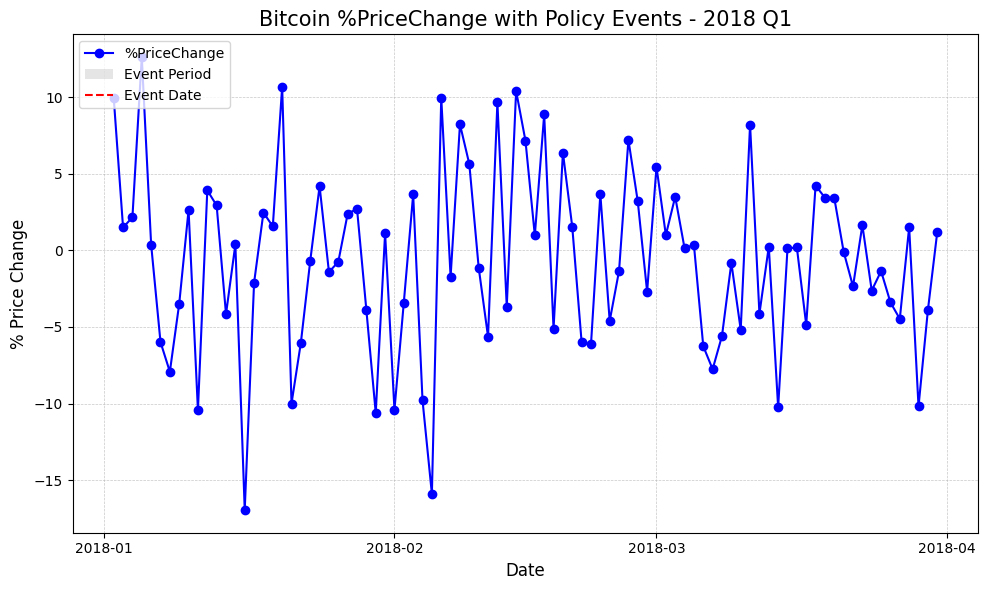

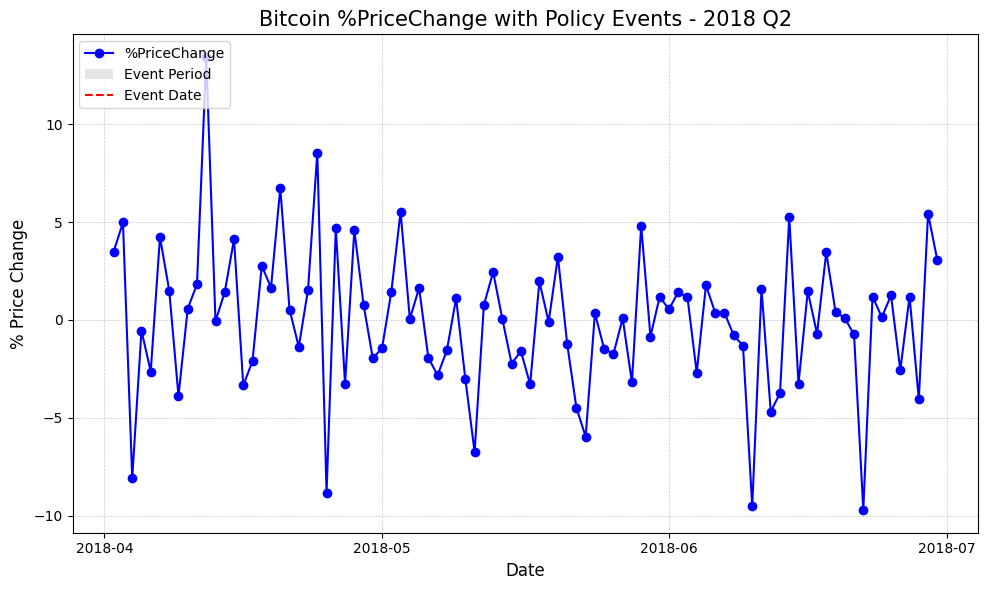

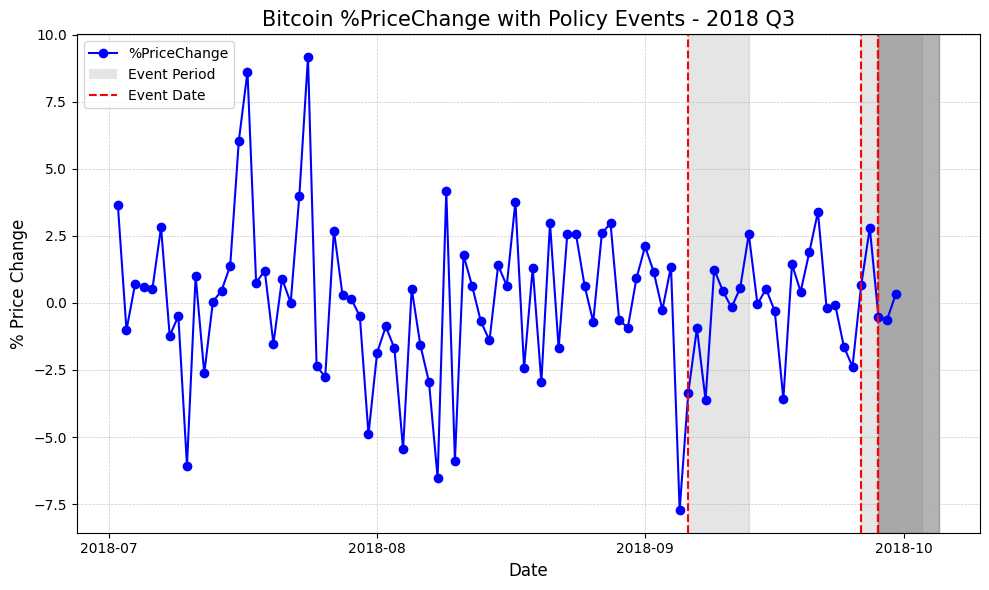

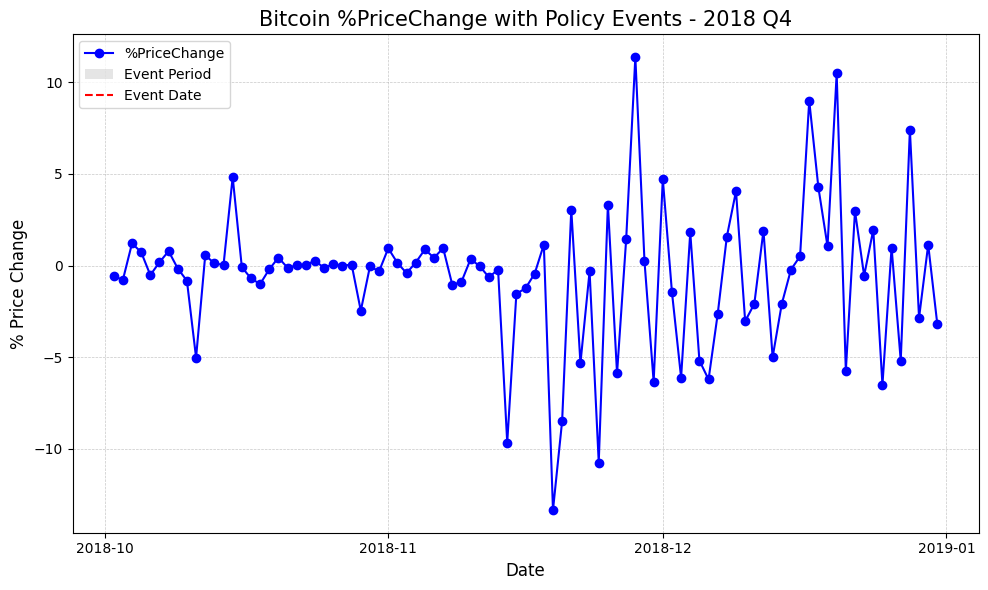

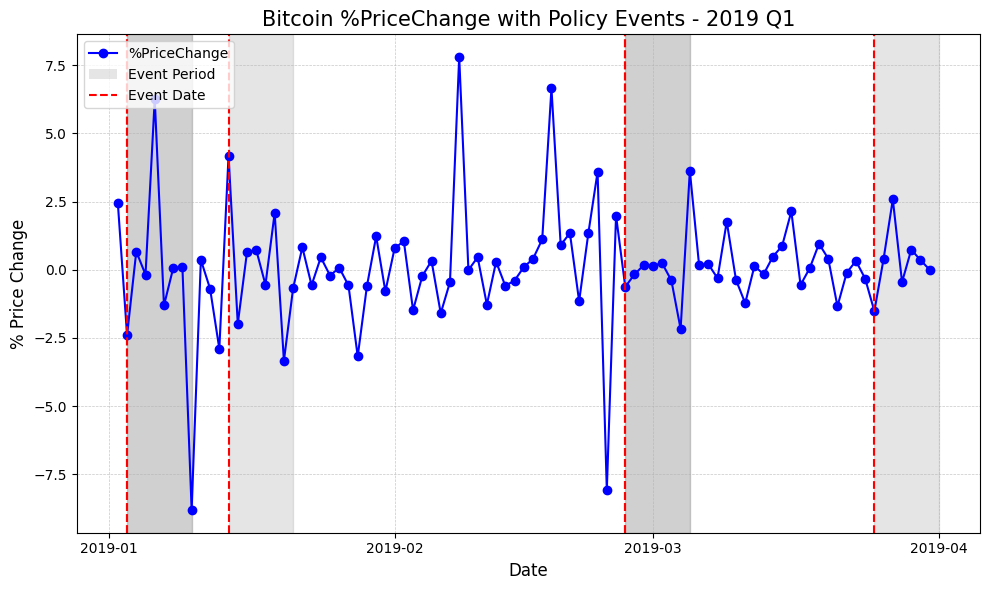

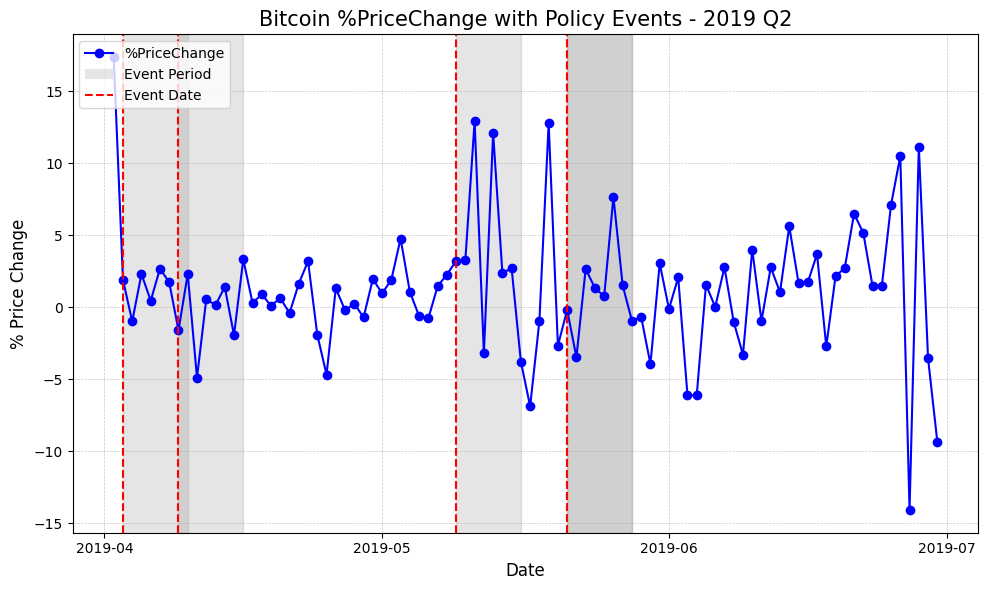

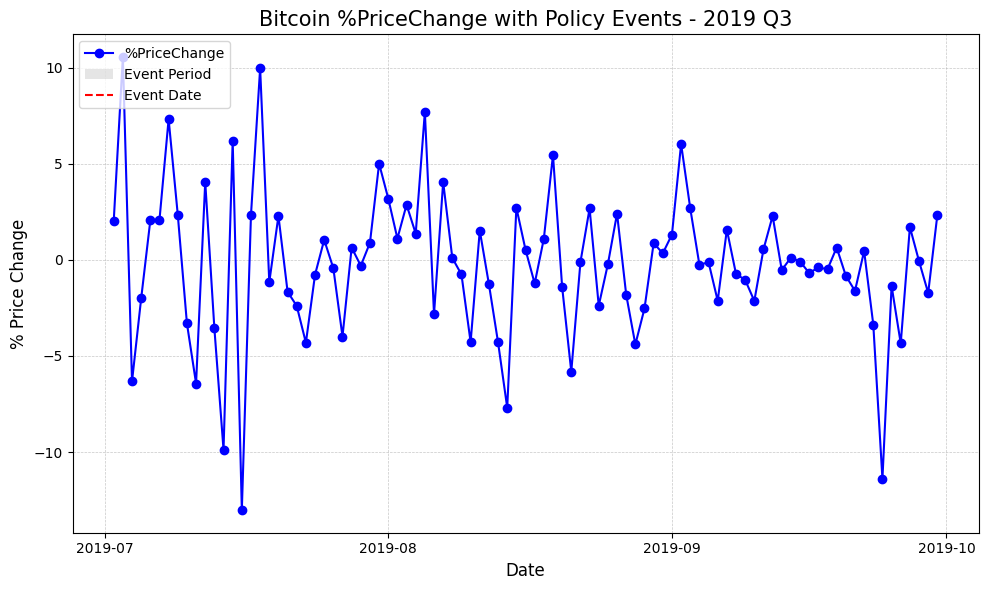

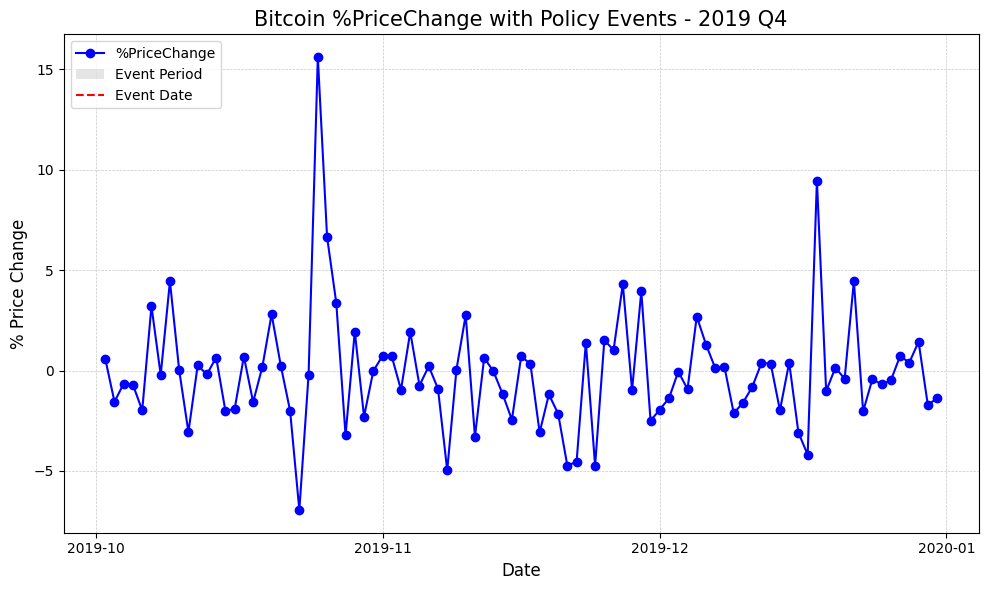

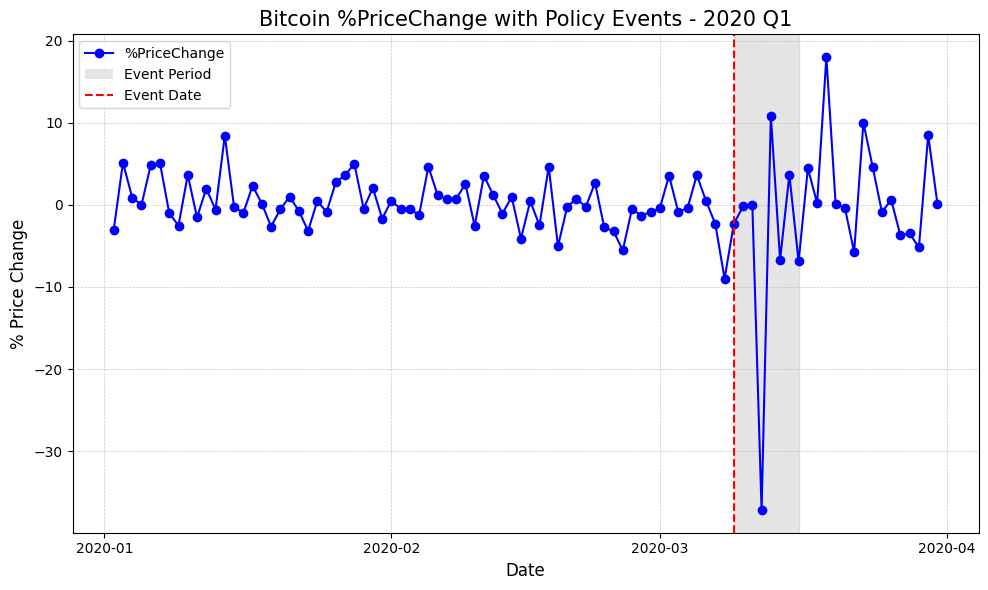

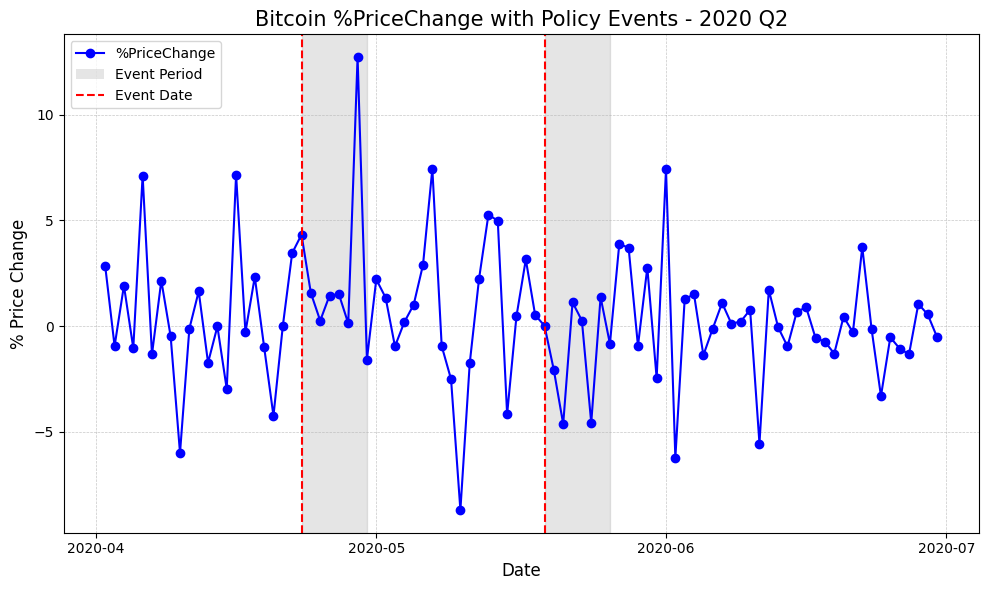

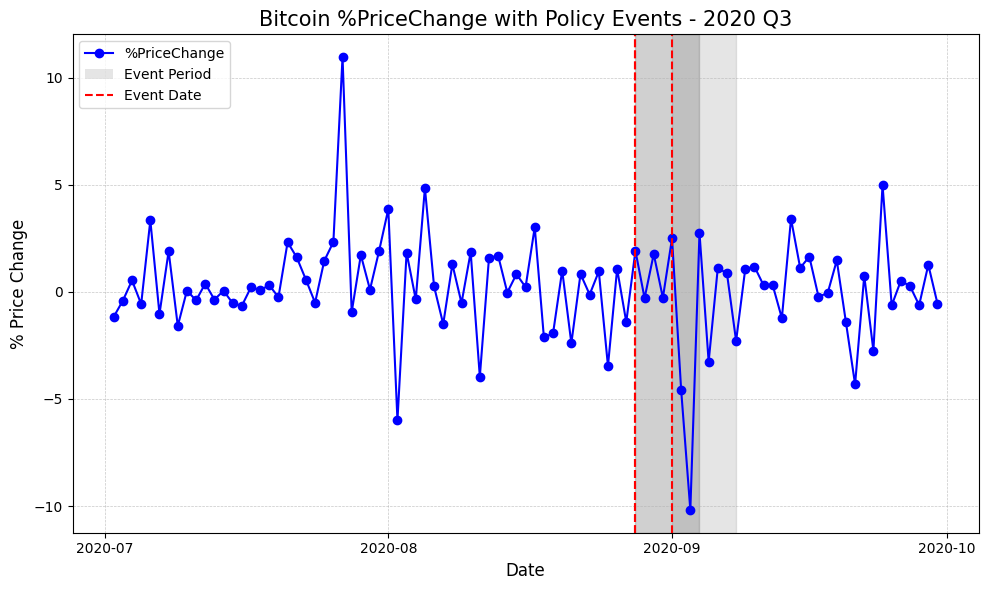

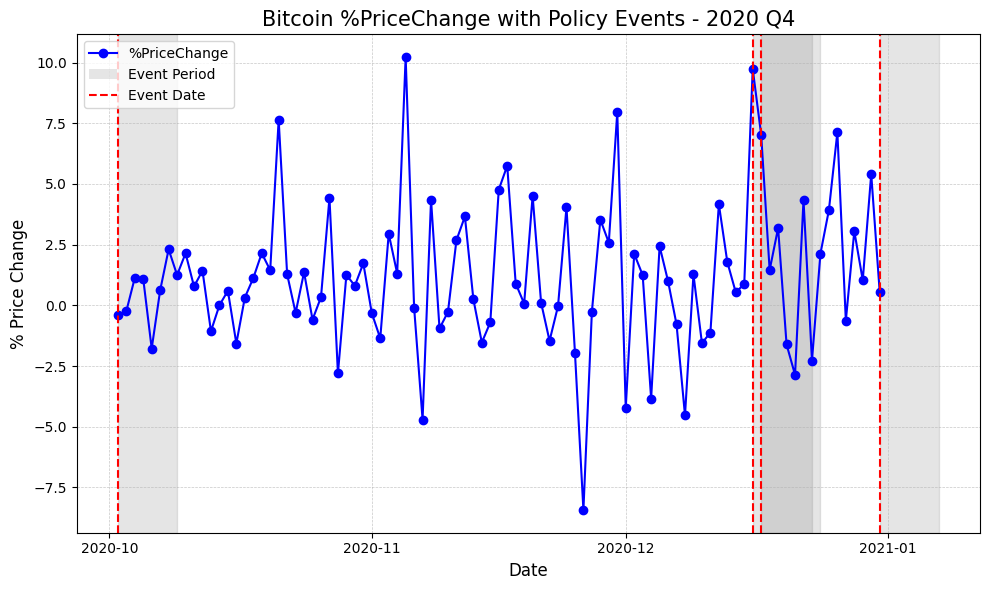

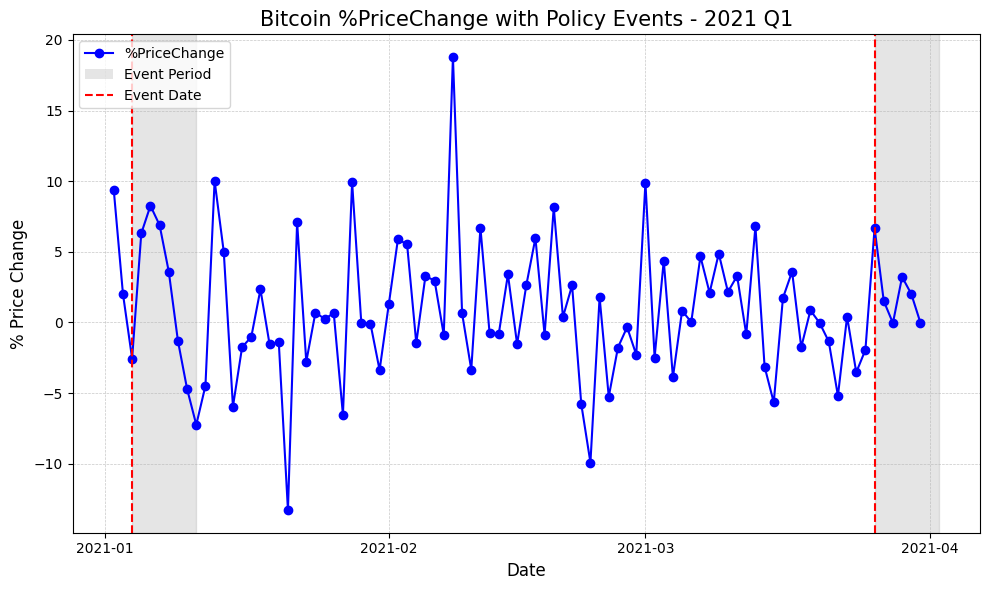

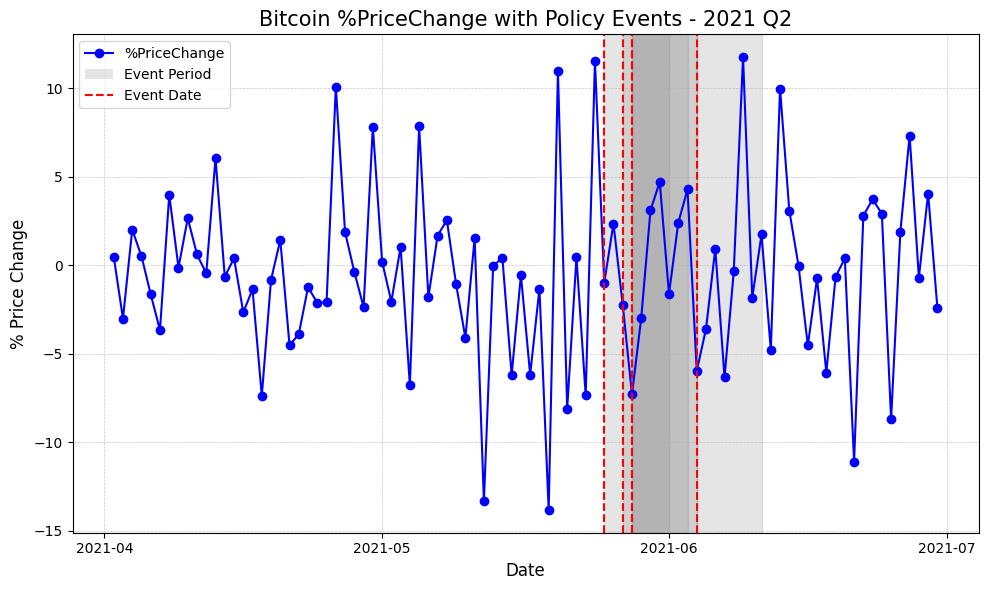

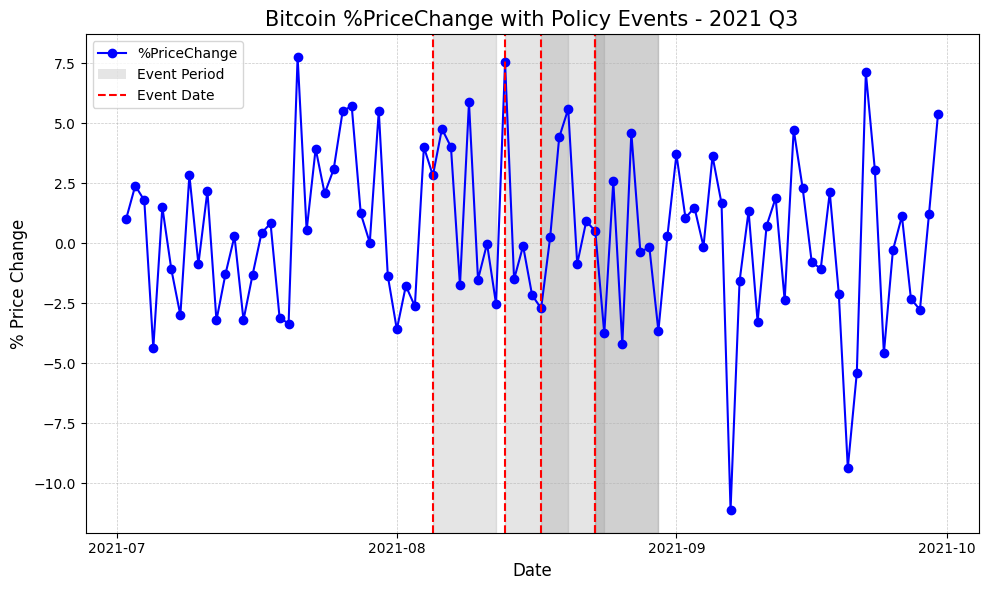

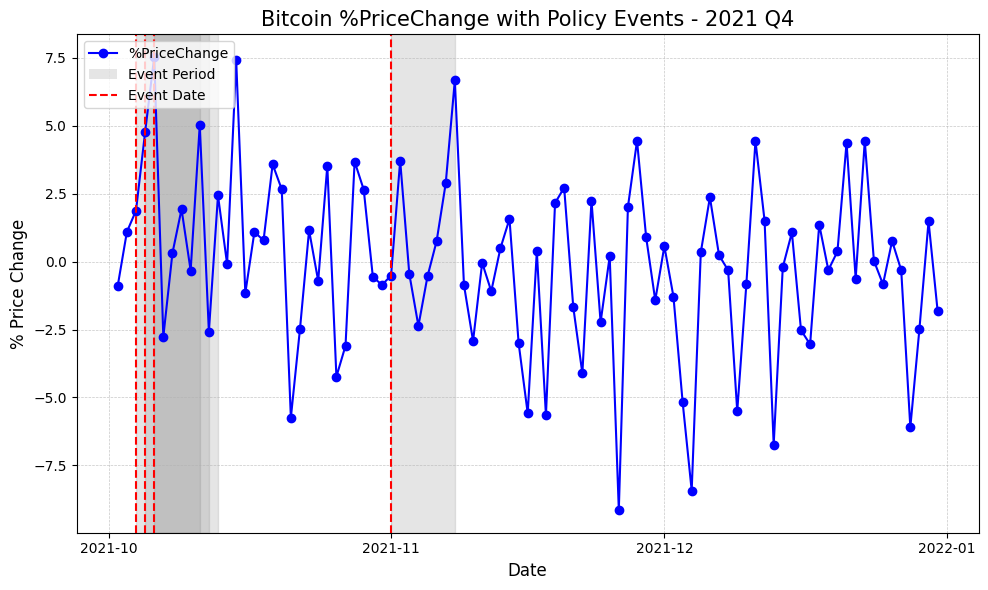

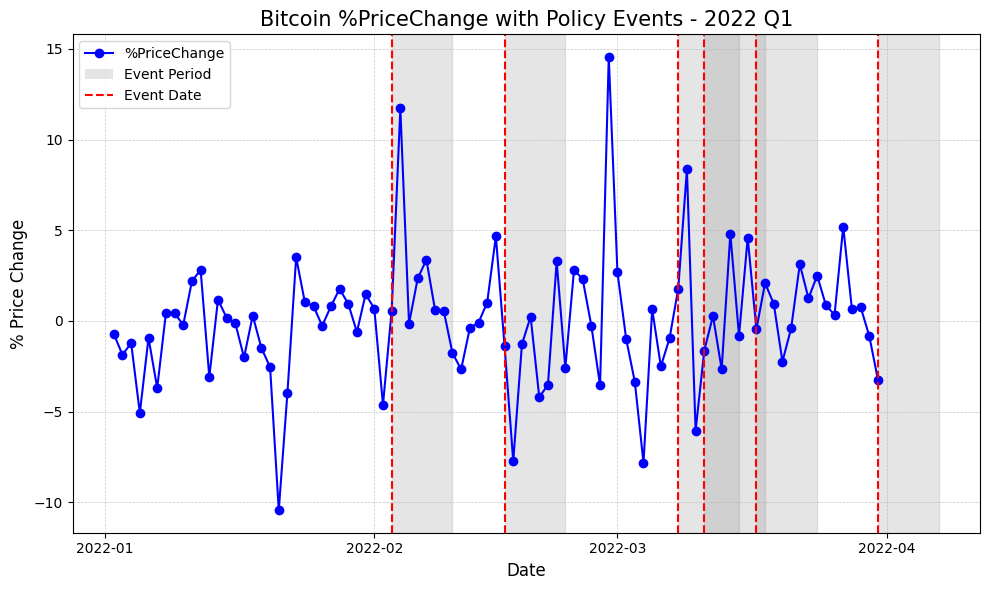

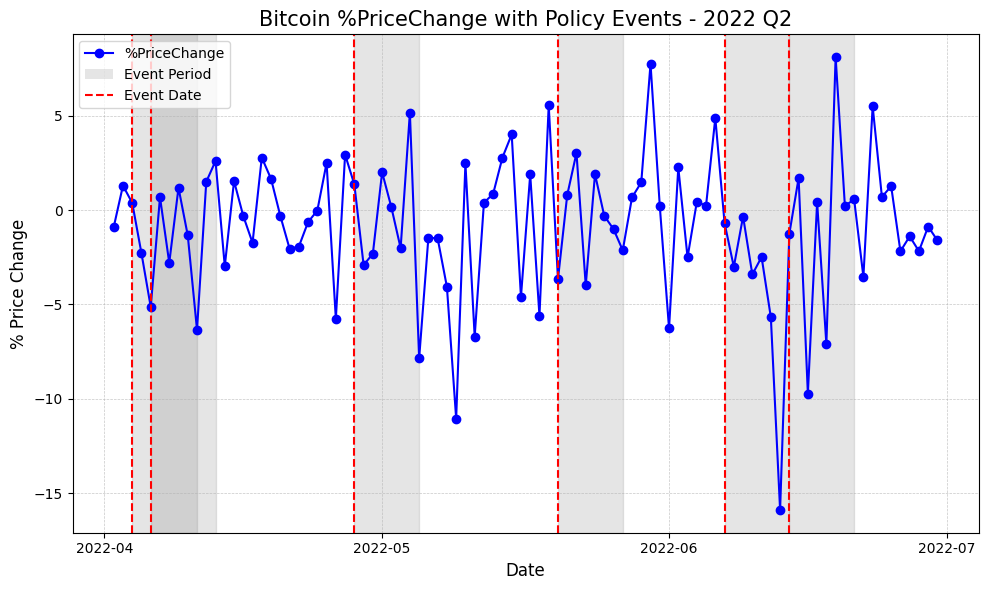

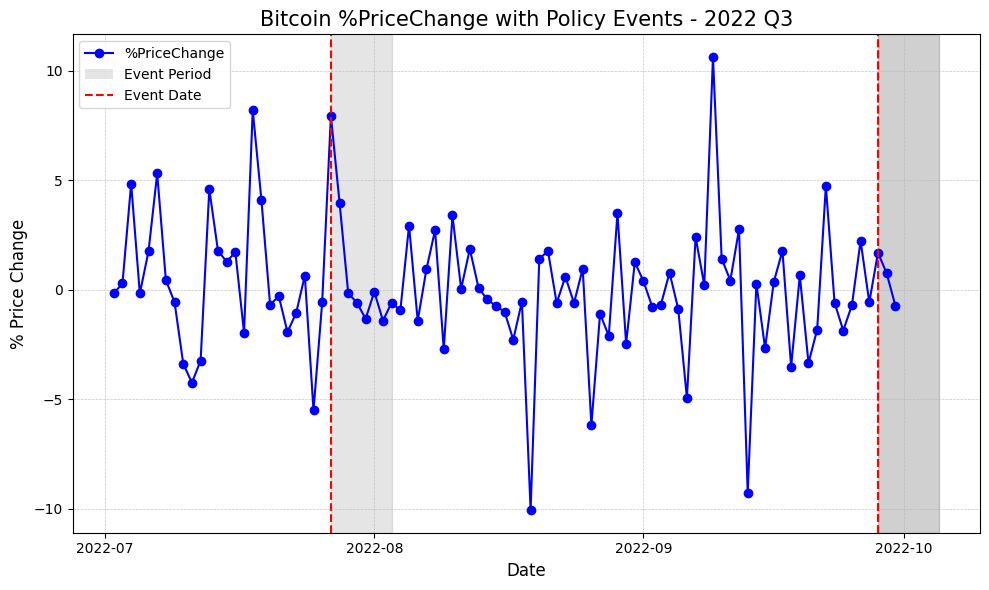

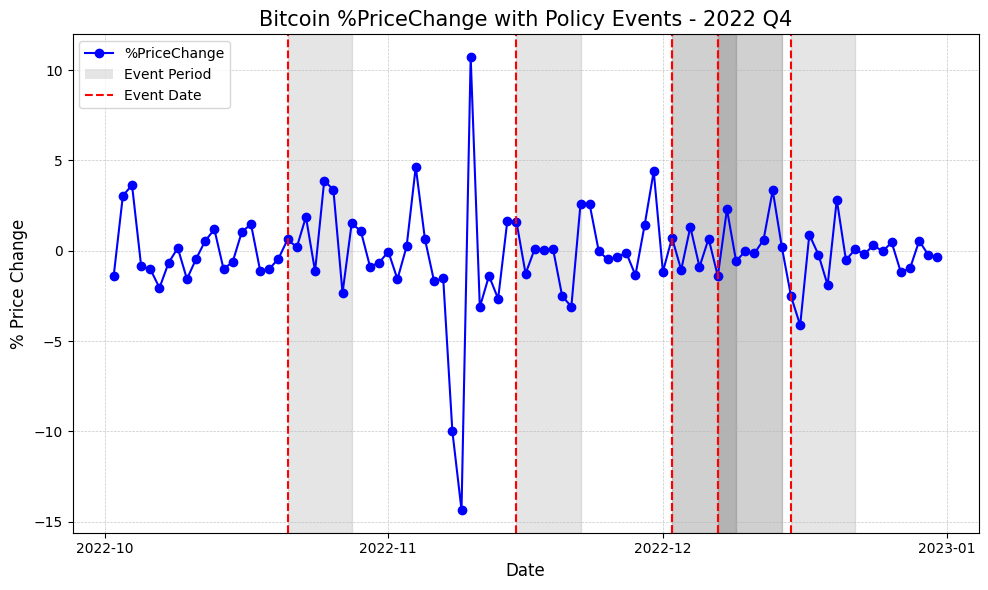

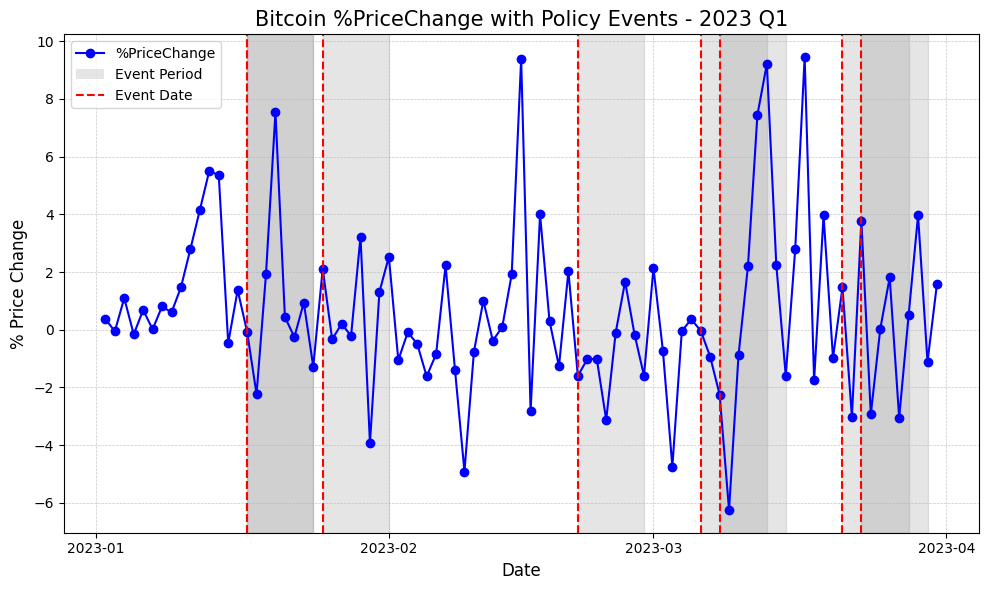

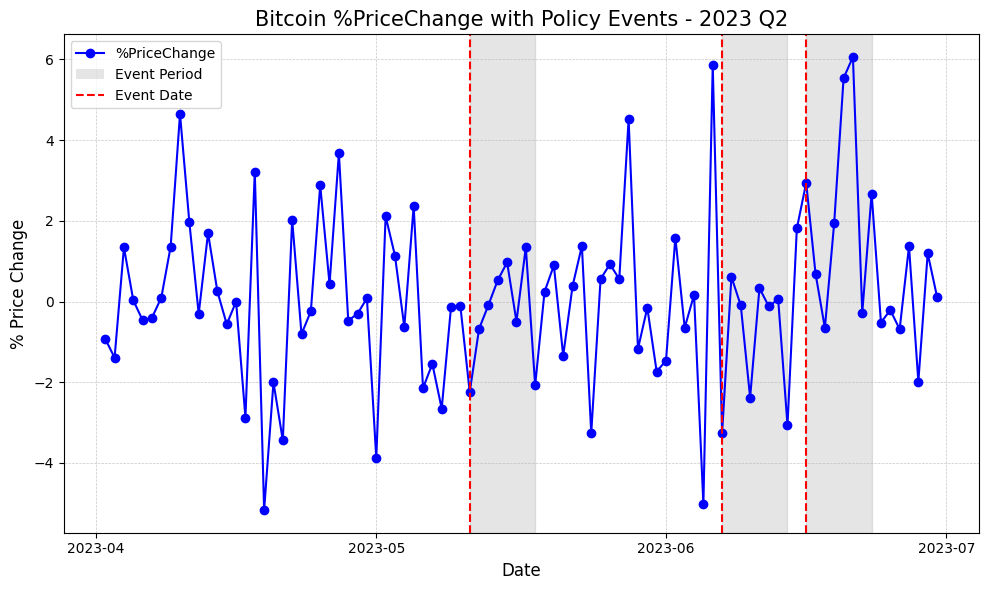

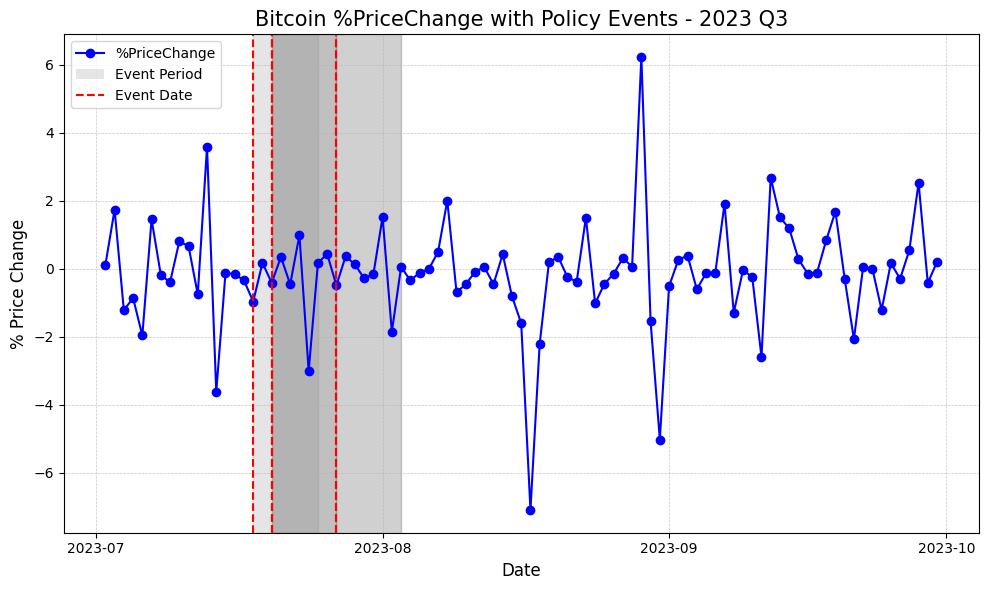

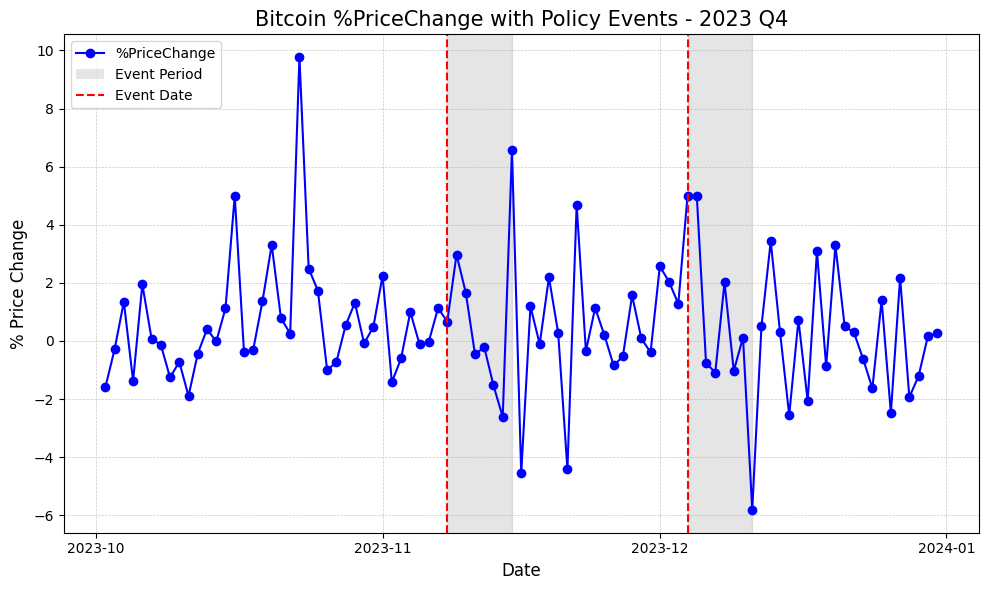

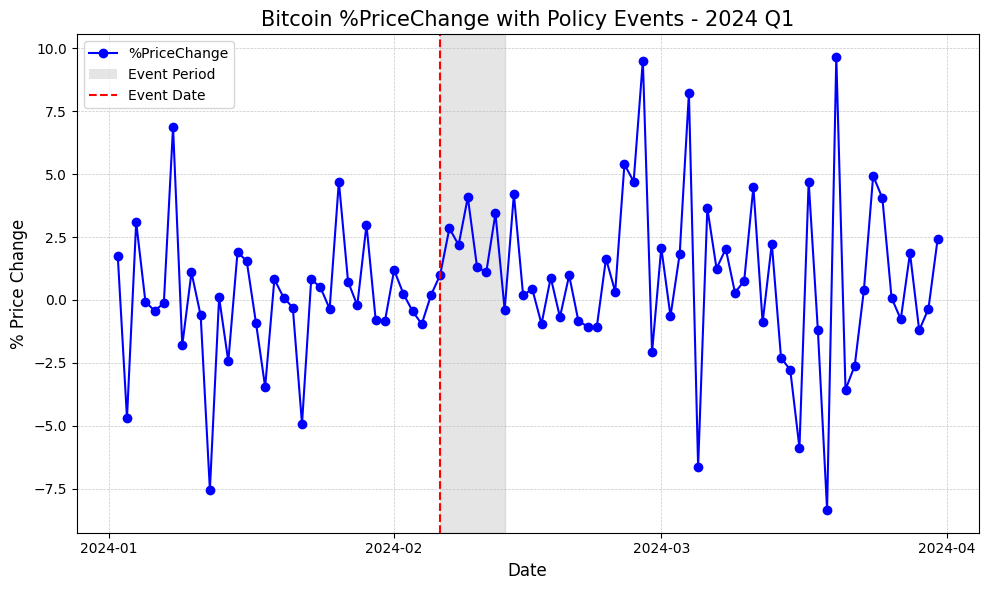

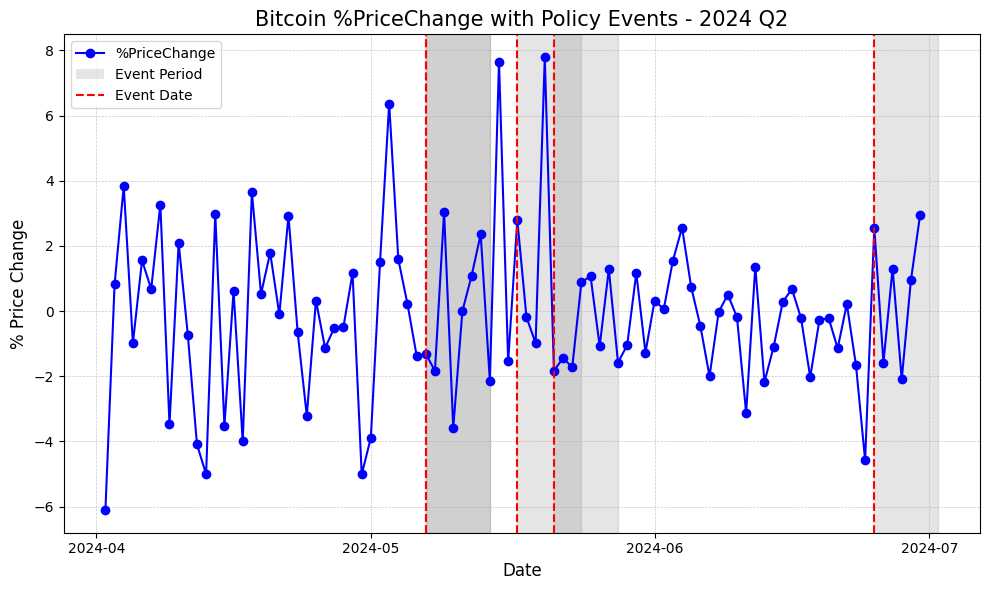

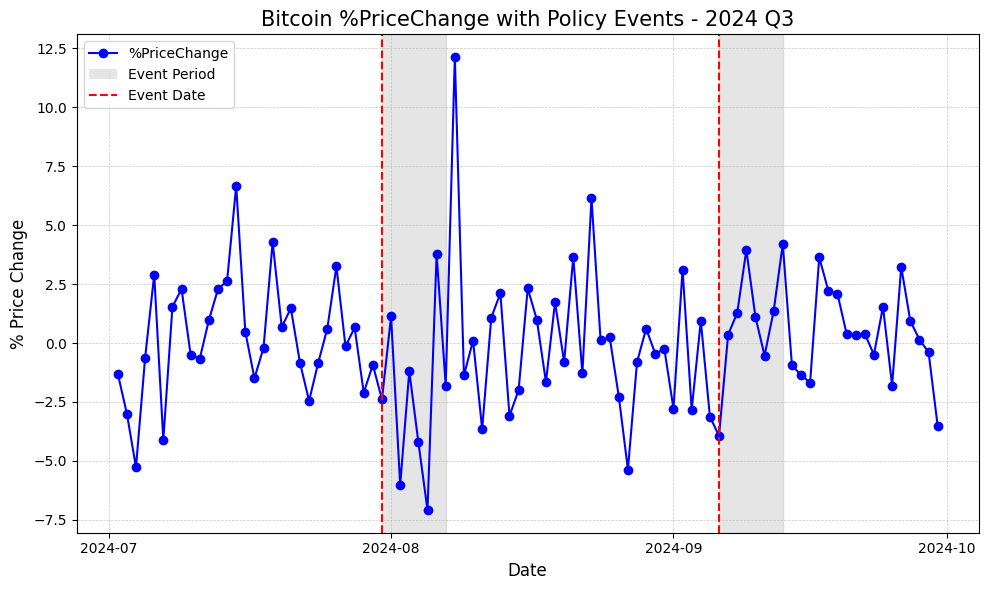

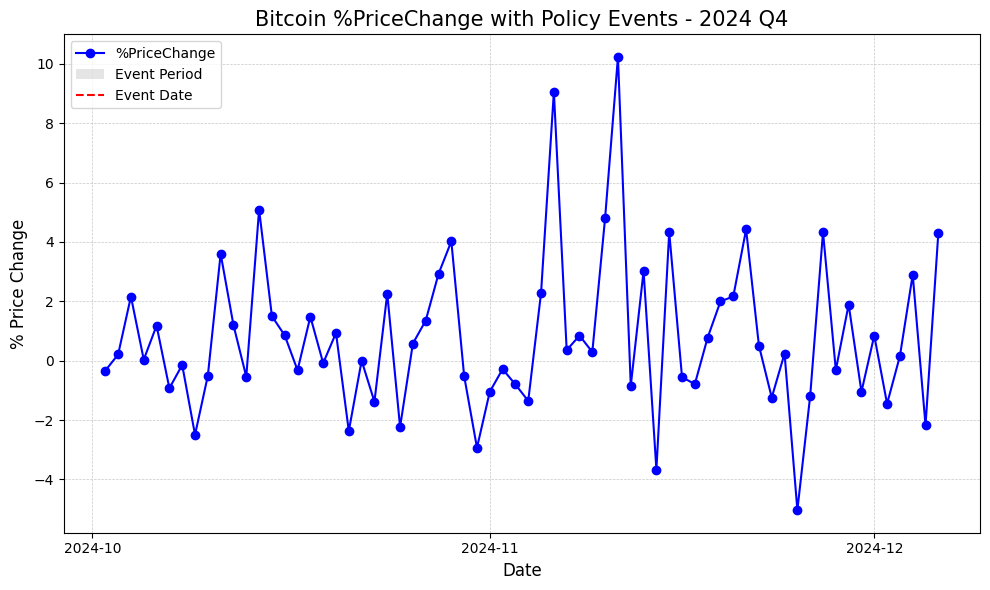

In [23]:
plot_quarterly_trend(bitcoin_df, law_df, '%PriceChange')

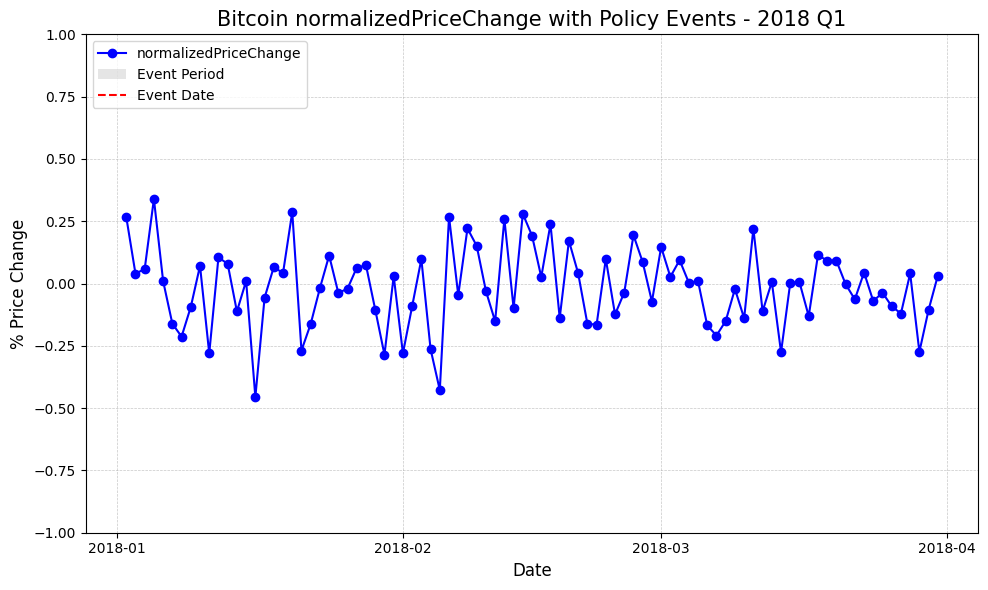

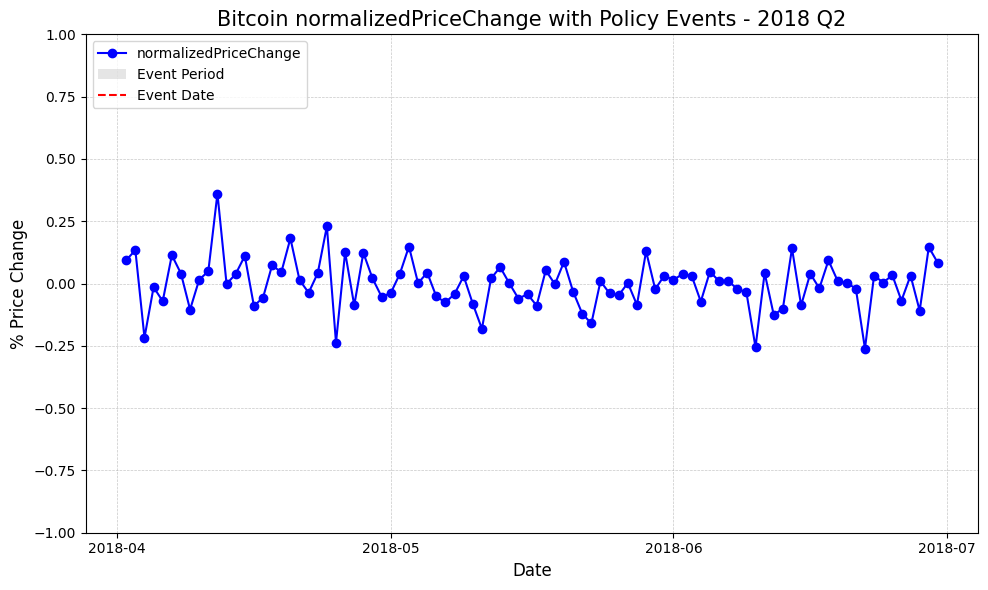

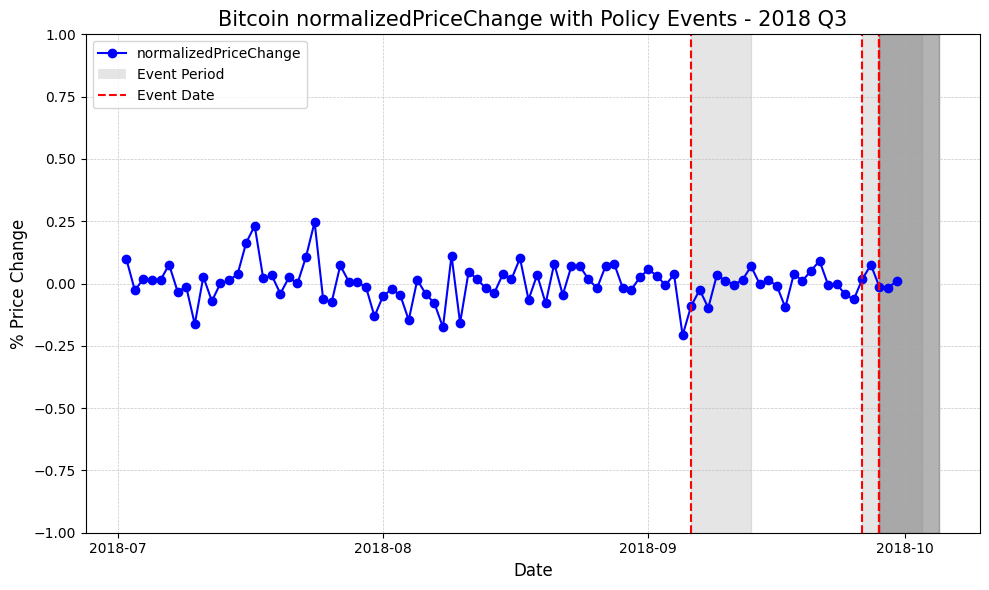

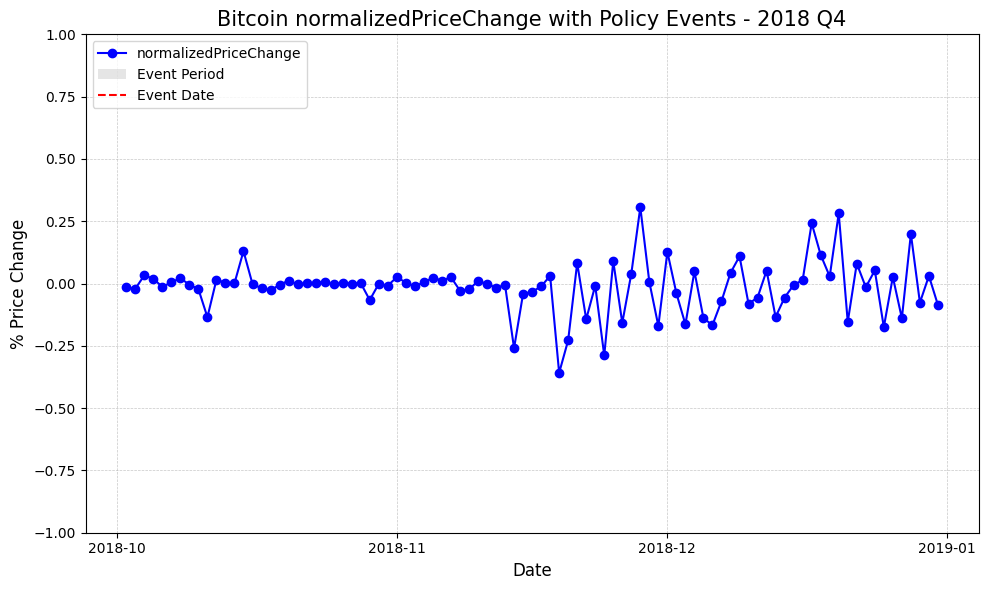

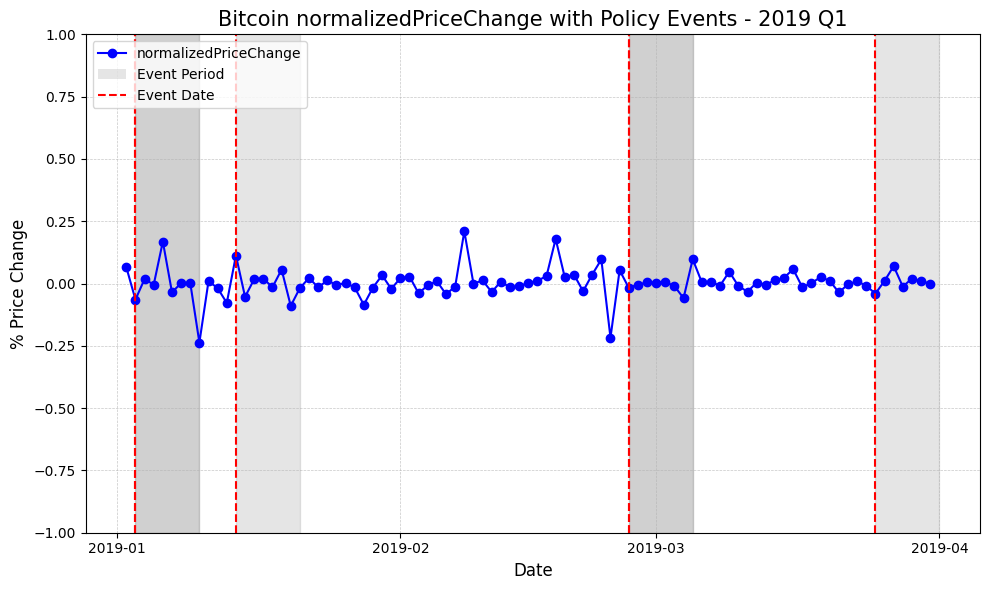

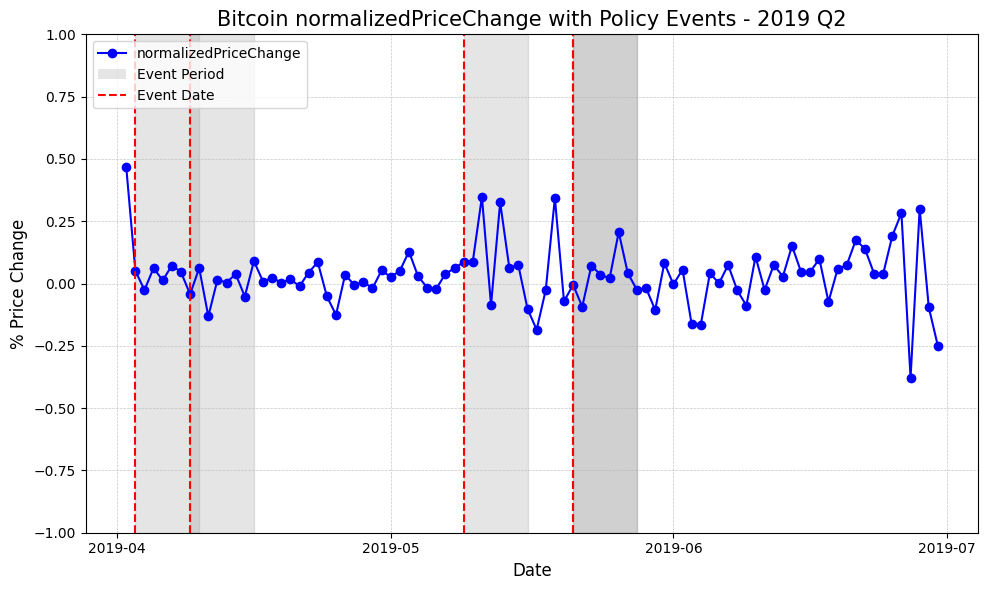

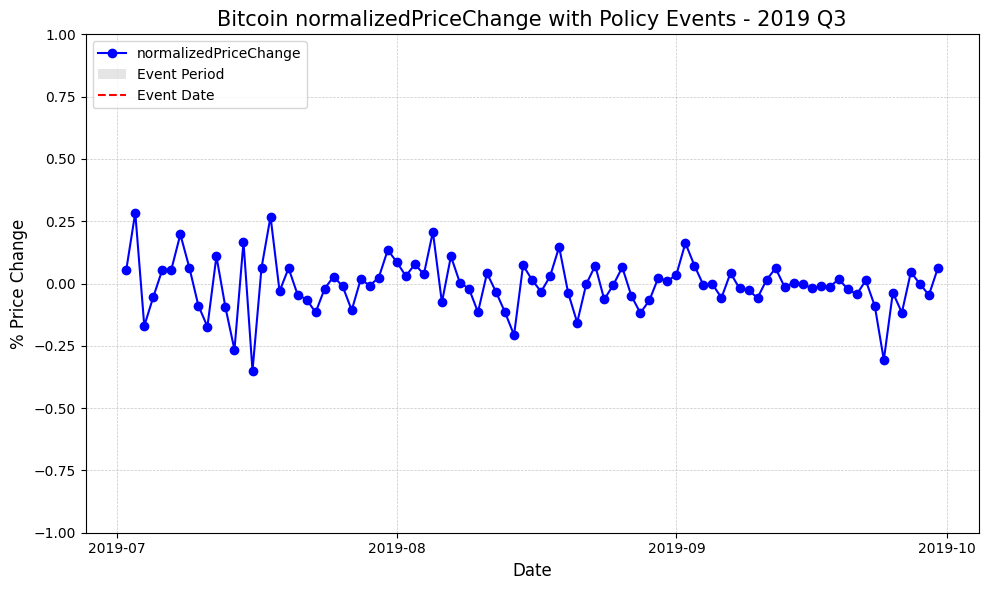

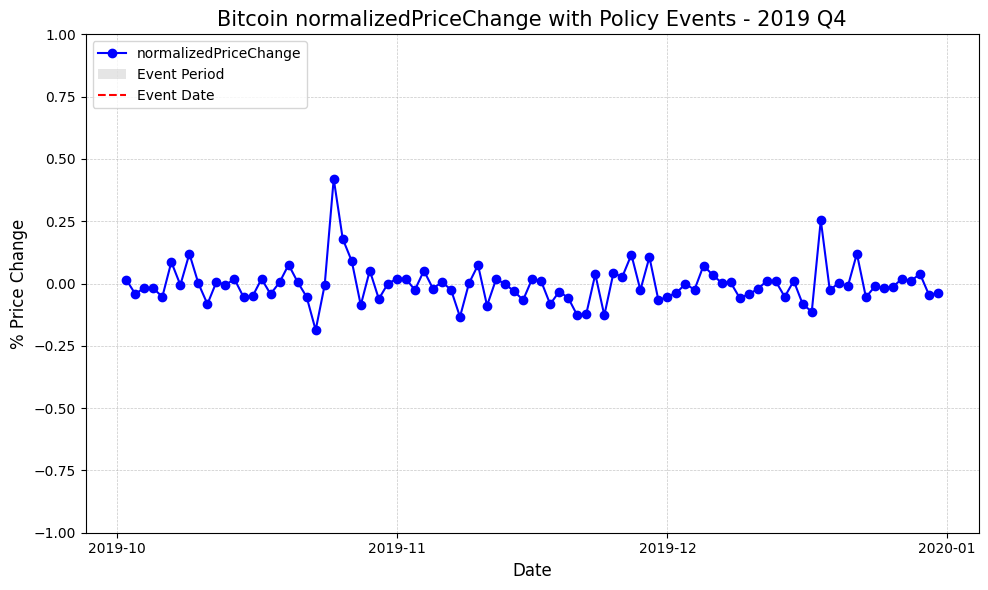

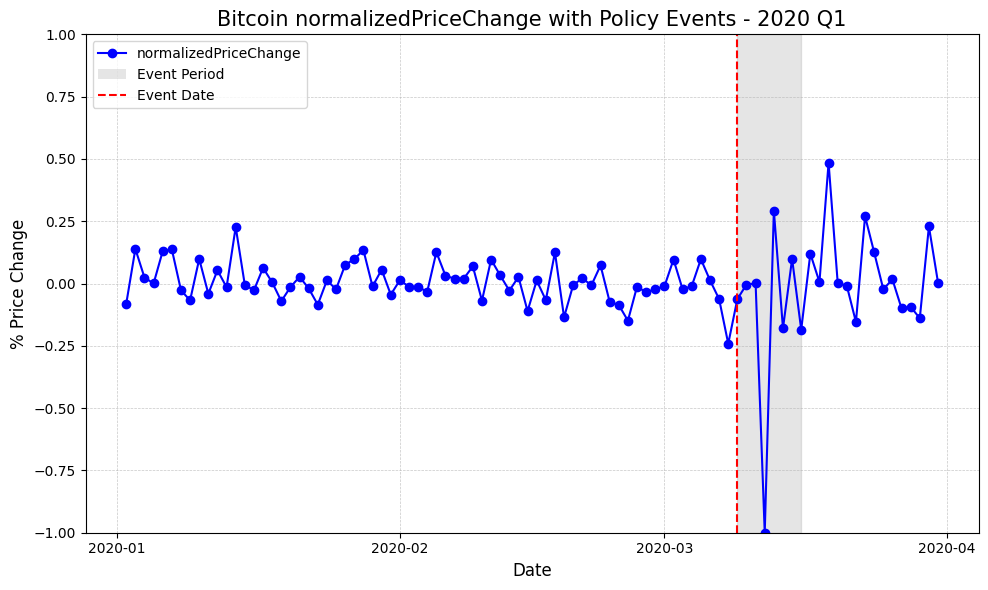

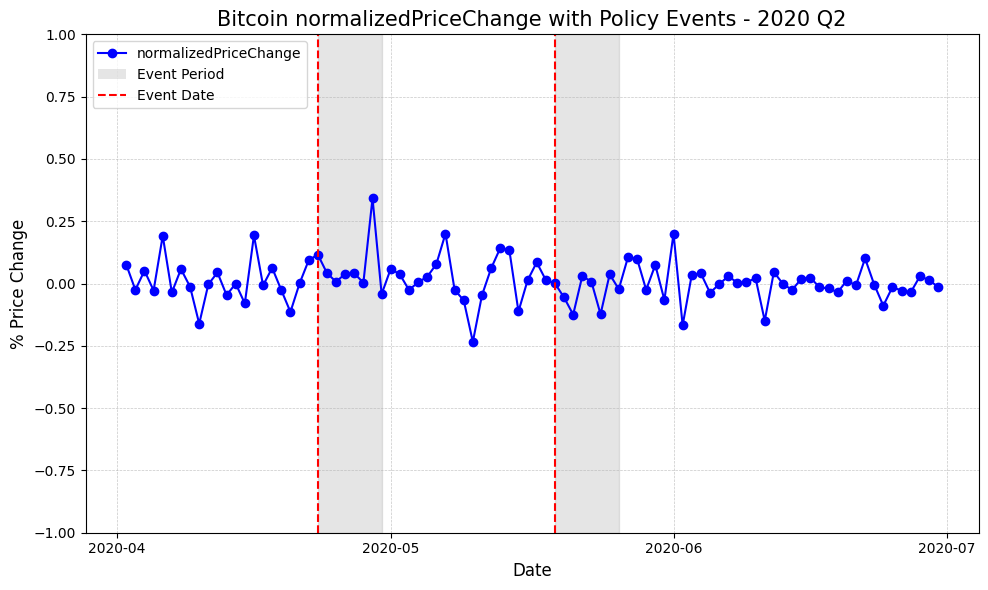

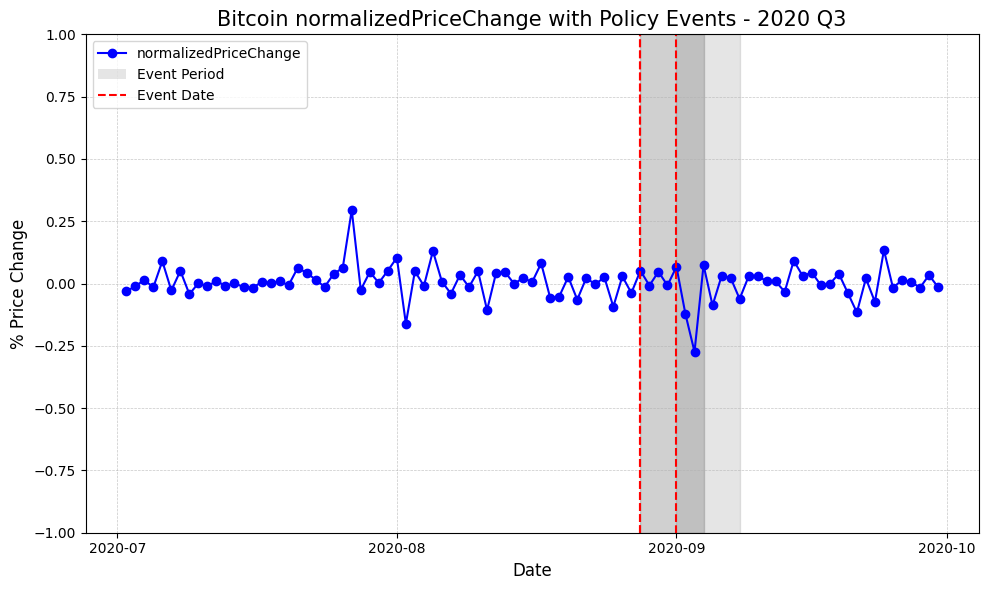

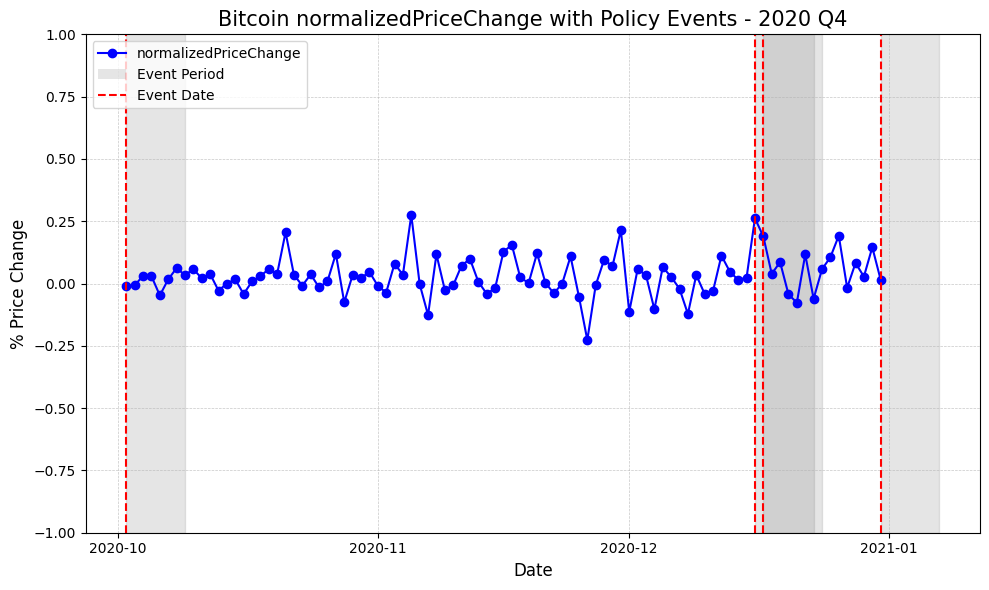

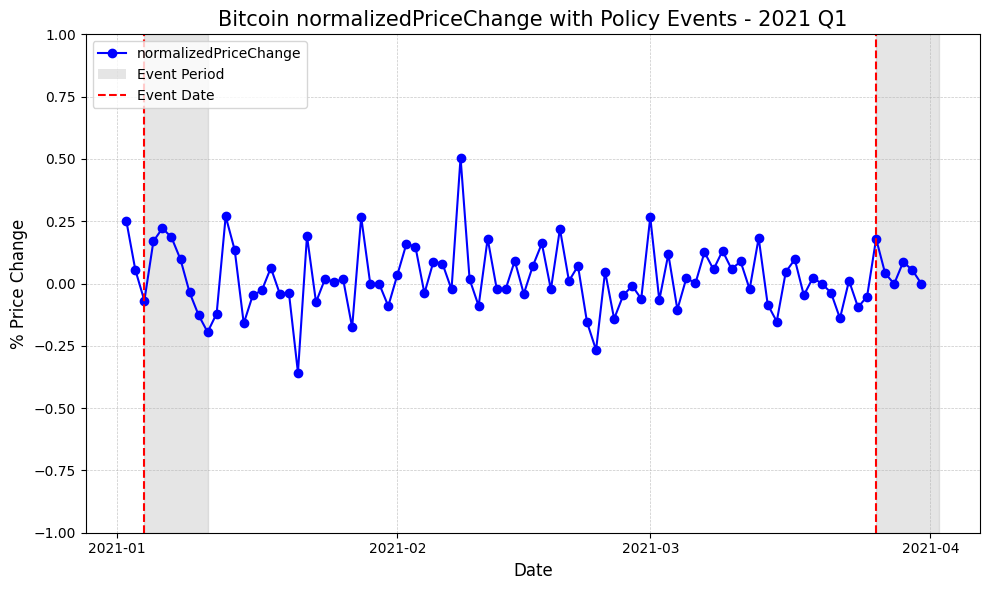

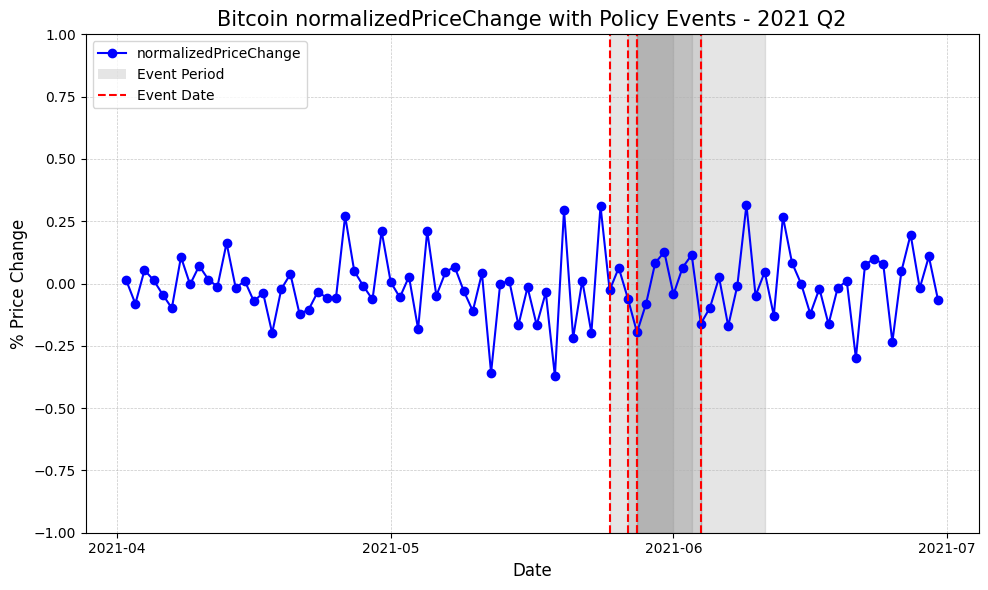

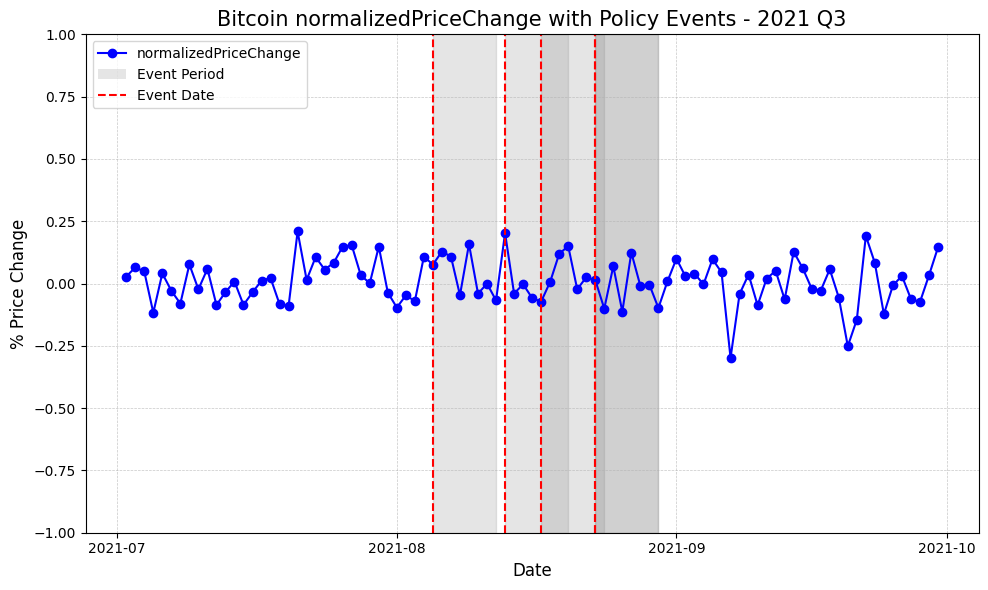

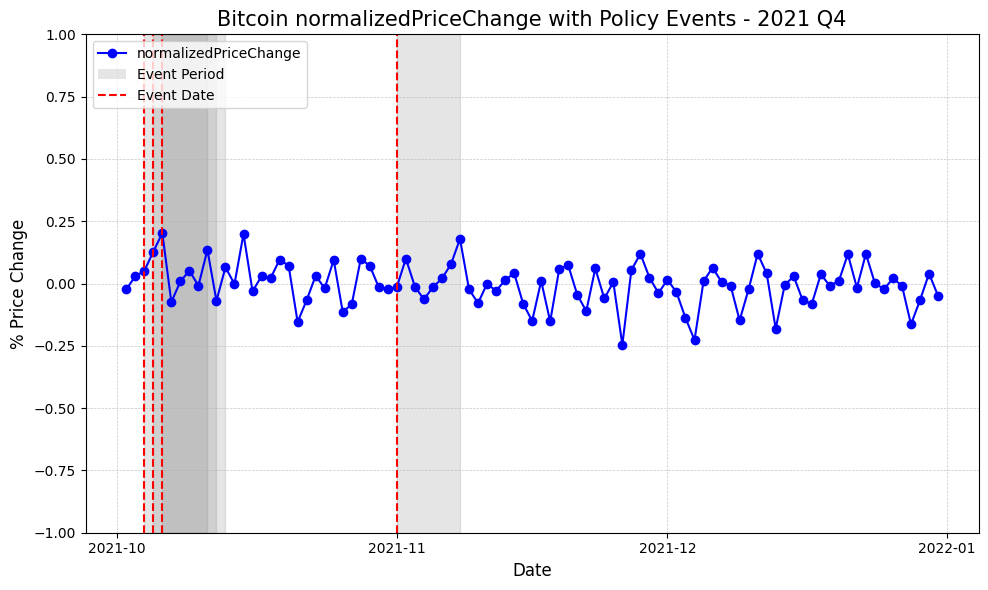

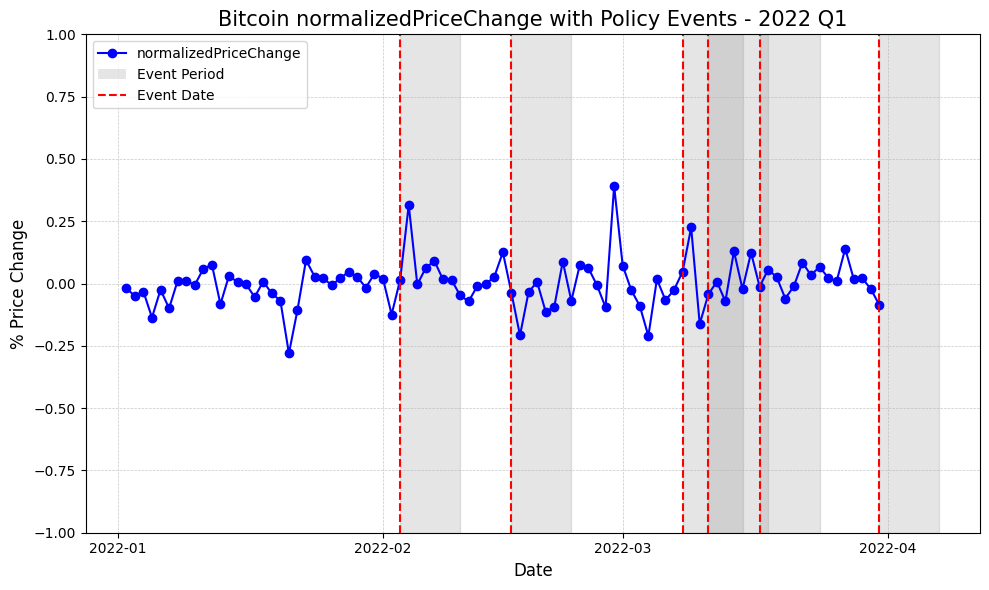

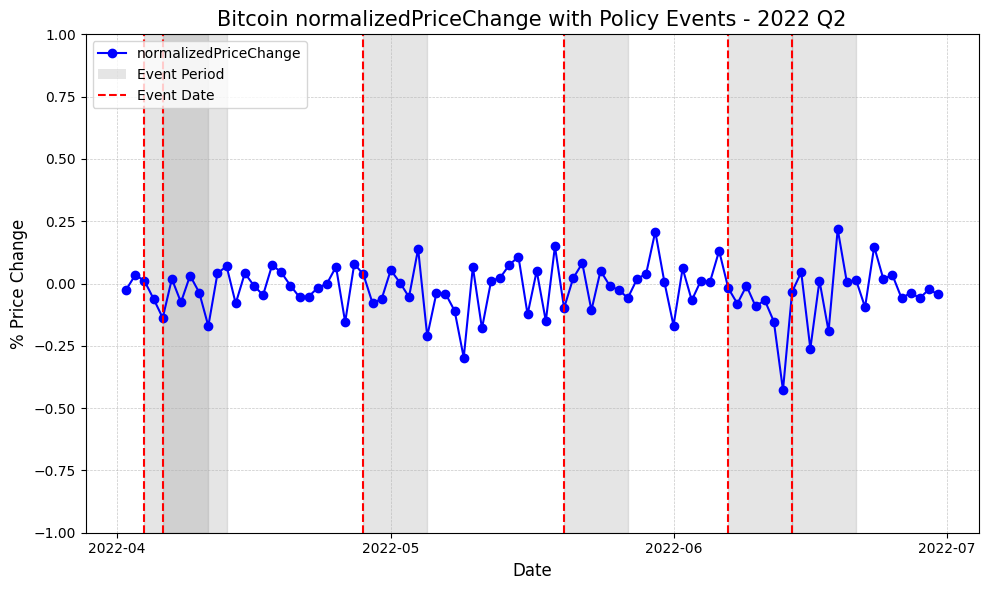

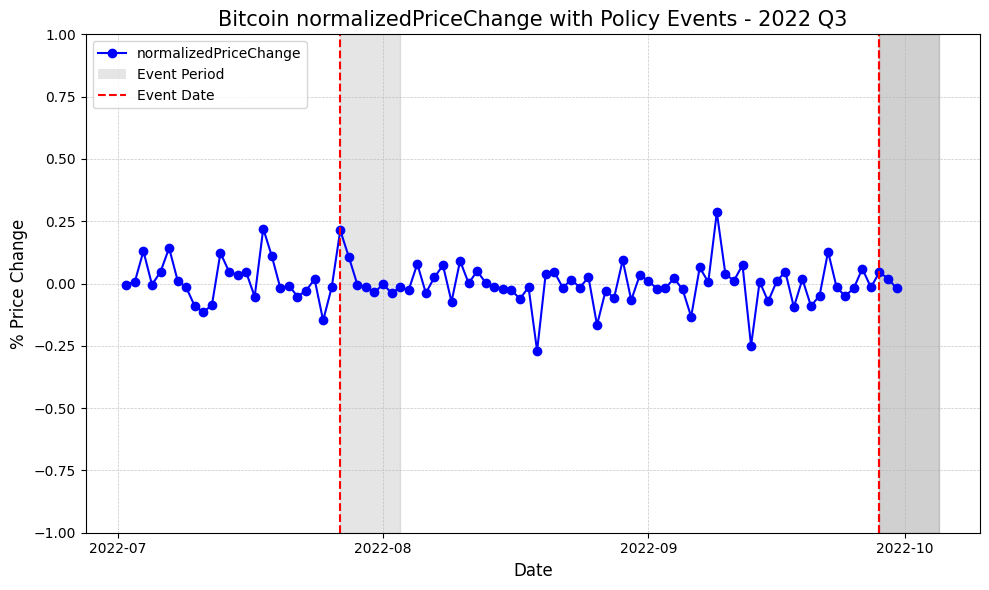

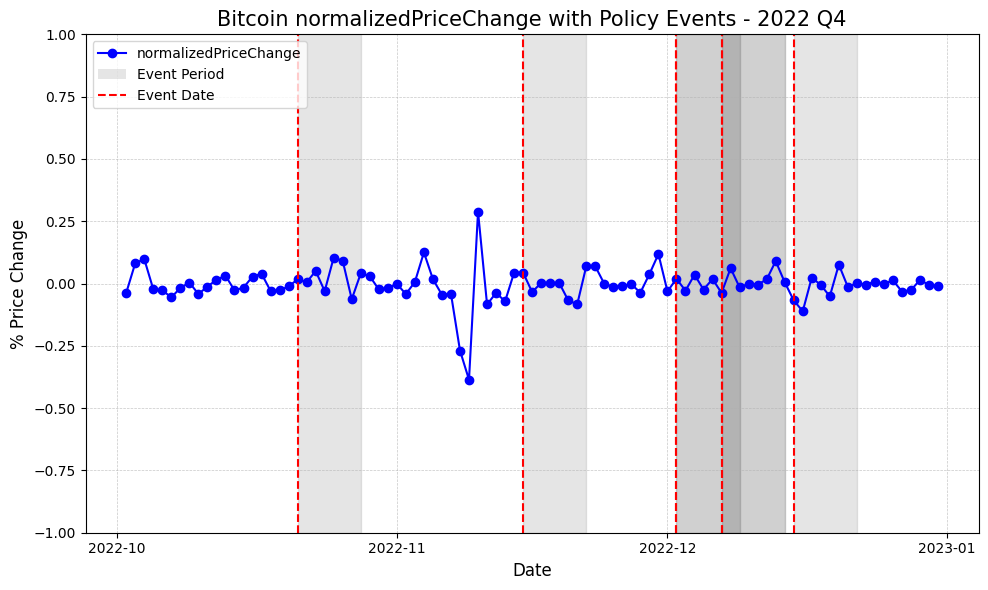

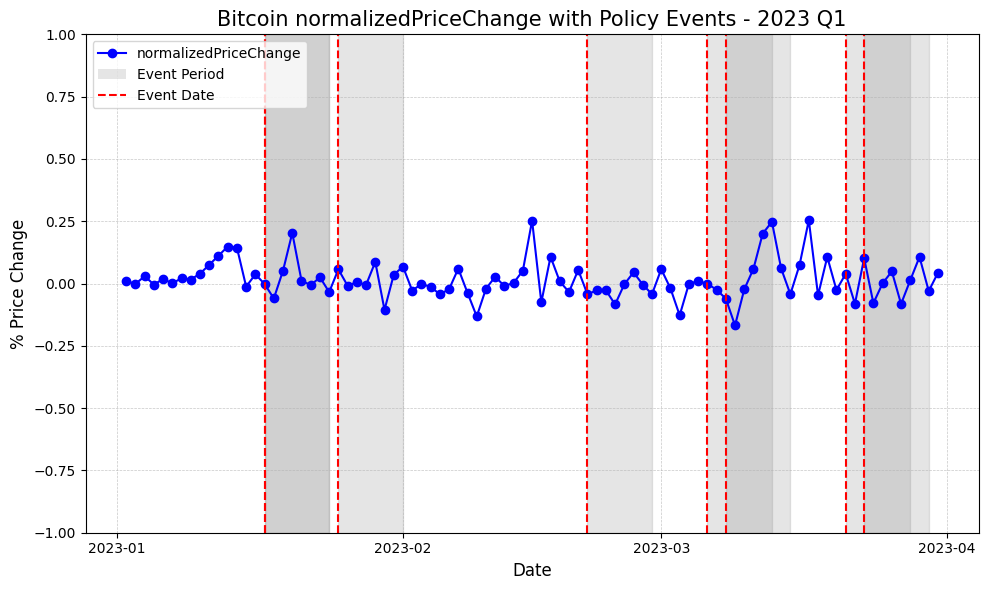

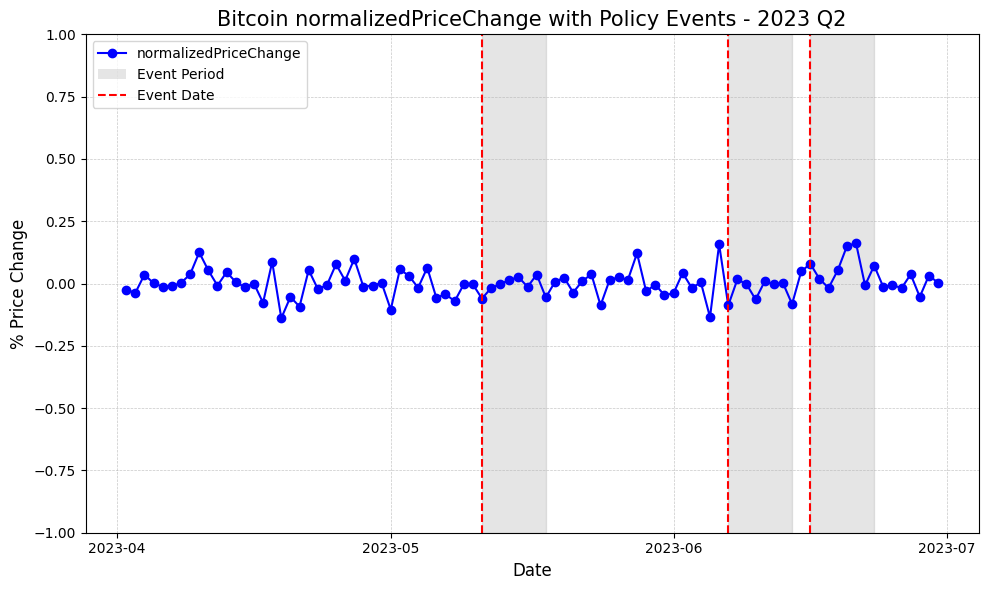

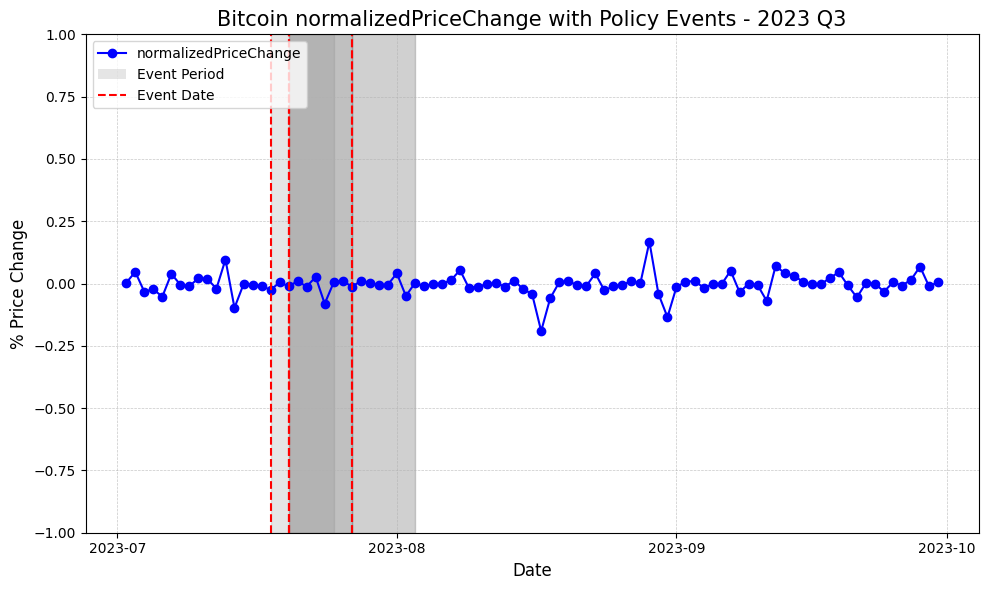

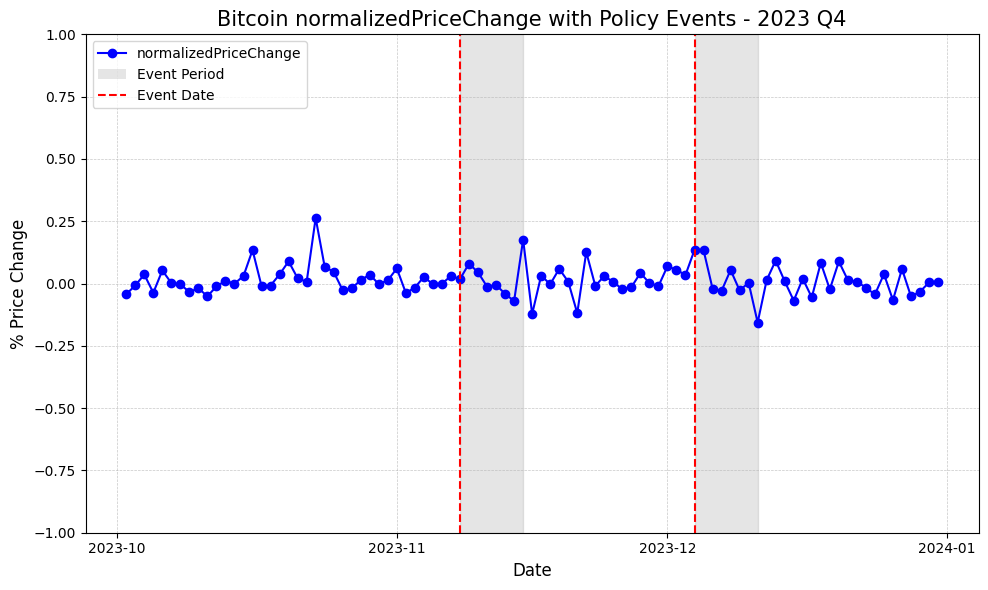

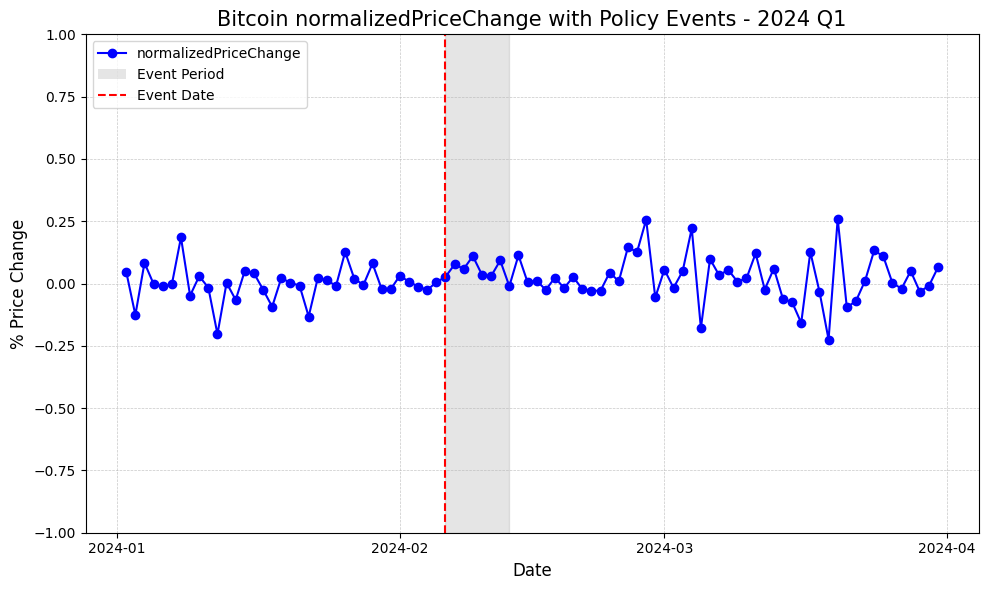

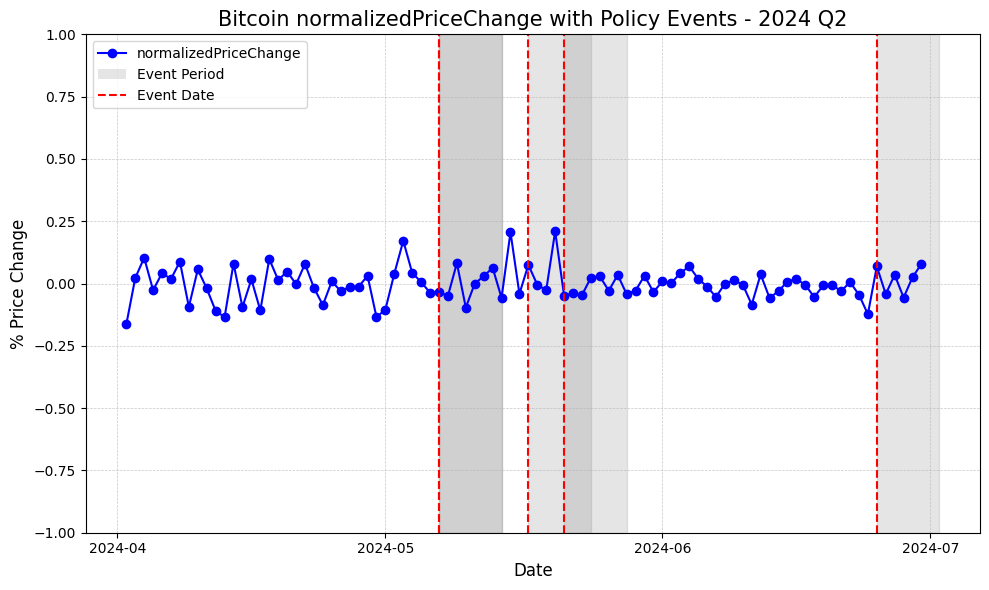

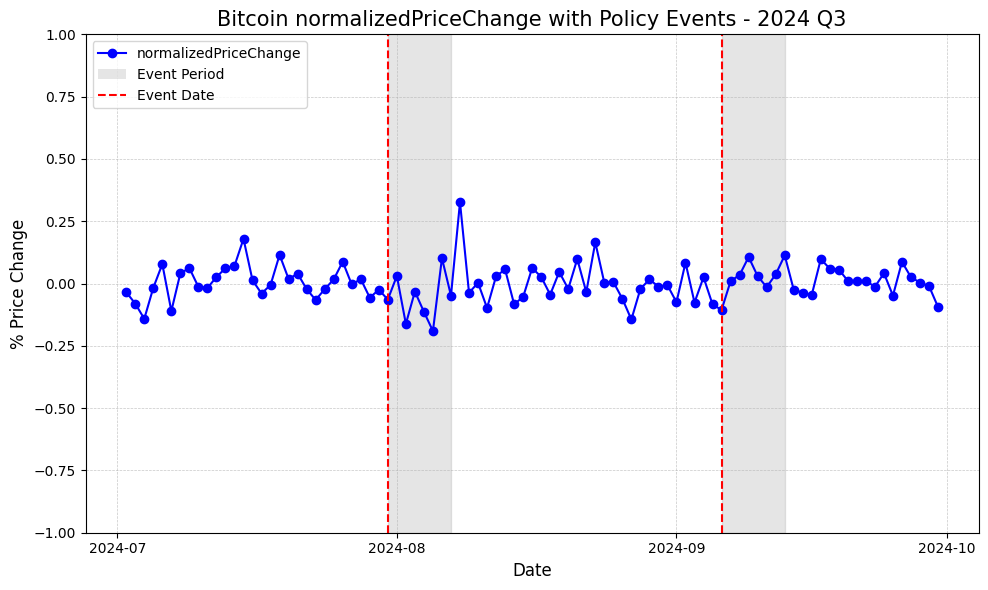

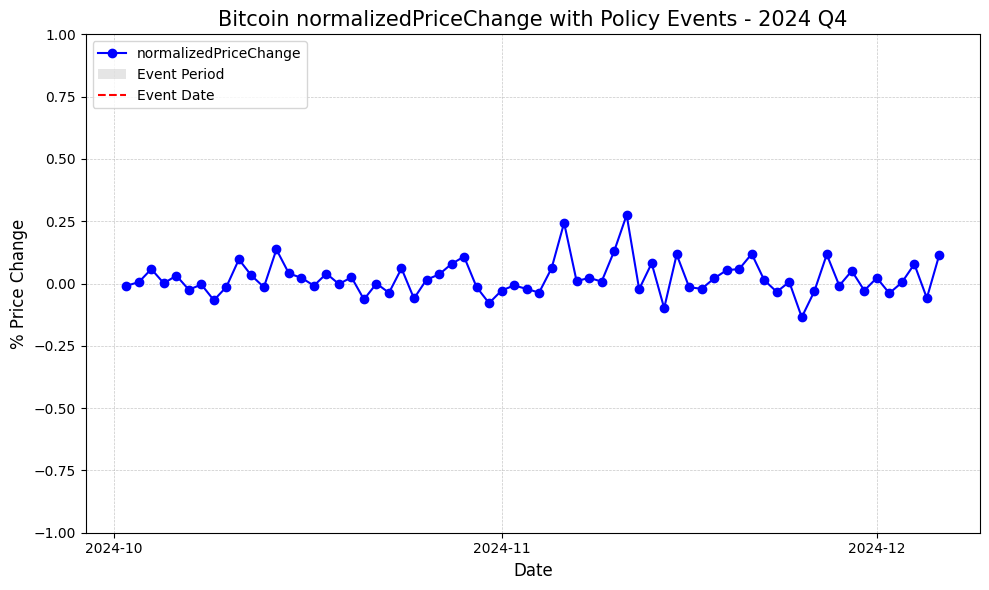

In [24]:
plot_quarterly_trend(bitcoin_df, law_df, 'normalizedPriceChange', y_axis_limit = True)